# Text Classification (Spam and Non-spam Texts)

This file contains the algorithm (along with complete description) for classification of spam and non-spam text messages using different well-known feature extraction techniques like Term Frequency, Inverse-Document Frequency, etc. and feature selection techniques like Variance Thresholding and Document Frequency Thresholding. Lingspam dataset was used for classification.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os, re
from collections import OrderedDict, Counter
from sklearn.utils import shuffle
import pandas as pd

# Data Loading

1. Loading dataset of spam and non-spam messages obtained from http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz. Each file contains raw text message and the classes (spam(1) and non-spam(0)) can be identified by th presence or absence of the substring 'spmsg' in the filename. Each file is a txt file.

In [205]:
lingspam_dataset_dir = "spam_dataset\\lingspam_public\\bare\\"

raw_text_all = []  # List of raw text data
labels_all = [] # Labels for each raw data
label_map = ['not spam', 'spam']
lingspam_file_ext = "txt"
spam_file_identifier = "spmsg"


# Load dataset
def extract_text_and_class(fp):
    # Read the contents from the file
    with open(fp, 'r') as f:
        text = f.read()
    # If content is available
    if len(text) > 0:
        # Add the class as a spam if the file name has specified substring
        if spam_file_identifier in fp:
            label = 1
        else:
            label = 0
        return text, label
    return None, None
        
def load_lingspam_data_urls(url, data=[]):
    # If the current url is a directory, then load tet files recursively
    if os.path.isdir(url):
        # For each file in the current directory
        for file in os.listdir(url):
            fp = os.path.join(url, file)
            # If the file is a directory, then load data from it
            if os.path.isdir(fp):
                data = load_lingspam_data_urls(fp, data)
            # Else if the file is a text file
            elif os.path.isfile(fp) and lingspam_file_ext in fp:
                data.append(fp)  # Add url of the file
    # Else if the current url is a text file
    elif os.path.isfile(fp) and lingspam_file_ext in fp:
        data.append(fp)  # Add url of the file
    return data    
                
raw_urls = load_lingspam_data_urls(lingspam_dataset_dir, [])
raw_urls = shuffle(raw_urls)

total_samples = 2000  # Total max data samples
spam_samples = int(total_samples/2)  # Total max samples containing spam texts
nonspam_samples = total_samples - spam_samples # Total max samples containing non-spam texts



spam_counter = 0
nspam_counter = 0
i=0
#while (spam_counter < spam_samples) or (nspam_counter < nonspam_samples):
while i < len(raw_urls):
    #print("Left: " + str(total_samples - len(raw_text)))
    text, label = extract_text_and_class(raw_urls[i])  # Extract the text and class
    if not (text is None):
        if label == 1 and (spam_counter < spam_samples):
            text = text.replace("\n", " ")  # Replace newline with space
            text = text.replace("\t", " ")  # Replace tab with space
            text = text.replace("\n", " ")  # Replace newline with space
            text = re.sub("\s+", " ", text)

            w = text.split(" ")
            n_w = []
            for j in range(len(w)):
                # Skip words containing single character
                if len(w[j]) > 1:
                    n_w.append(w[j])
            raw_text_all.append(n_w)
            labels_all.append(label)
            spam_counter += 1
        elif label == 0 and (nspam_counter < nonspam_samples):
            text = text.replace("\n", " ")  # Replace newline with space
            text = text.replace("\t", " ")  # Replace tab with space
            text = text.replace("\n", " ")  # Replace newline with space
            text = re.sub("\s+", " ", text)

            w = text.split(" ")
            n_w = []
            for j in range(len(w)):
                # Skip words containing single character
                if len(w[j]) > 1:
                    n_w.append(w[j])
            raw_text_all.append(n_w)
            labels_all.append(label)
            nspam_counter += 1    
    i += 1
# Split Evaluation and training data
split_index = int(len(raw_text_all)*4/5)
raw_text_all, labels_all = shuffle(raw_text_all, labels_all)
raw_text, labels = raw_text_all[:split_index], labels_all[:split_index]
raw_text_eval, labels_eval = raw_text_all[split_index:], labels_all[split_index:]
print("Total samples collected: " + str(len(raw_text_all)) + ", Train:" + str(len(raw_text)) + ", Eval: " + str(len(raw_text_eval)))

Total samples collected: 1481, Train:1184, Eval: 297


In [206]:
all_samples =np.unique(labels_all, return_counts=True)[1]
train_samples = np.unique(labels, return_counts=True)[1]
eval_samles = np.unique(labels_eval, return_counts=True)[1]
print("Total (non-spam, spam) samples for All: " + str(all_samples) + ", Train: " + str(train_samples) + ", Eval: " + str(eval_samles))

Total (non-spam, spam) samples for All: [1000  481], Train: [798 386], Eval: [202  95]


# Data PreProcessing

## 1. Stop-Words
Remove stops from all texts in order to reduce the number of words in order to process. Stop-words are language-specific functional words, are frequent words that carry no information (i.e., pronouns, prepositions, conjunctions). In English language, there are about 400- 500 Stop words. Examples of such words include 'the', 'of', 'and', 'to'. The first step during preprocessing is to remove these Stop words, which has proven as very important. Many of the most frequently used words in English sentence are useless in Information Retrieval (IR) and text mining.

## Stop-Word Detection

The frequency of each word over single or multiple documents will be used to determine stop-words in a text. The words with an inter-document frequency greater than or equal 1 are considered as stop-words.

## Inter-Document Frequency over all documents

It is the number of times a word occurred across all documents divided by the total number of documents. It will provide an estimation of the frequency of the word per document. The  equation for Inter-Document Frequency '$F_R(W)$' for a word '$W$' is as follows:

\begin{equation}
F_R(W) = \frac{\sum_{i, j}^{n, m} X_j^{d_i}}{\sum_i^{n} 1}
\end{equation}

Here,

1. W = Word whose frequency needs to be determined

2. $X_j^{d_i}$ is 1 if the word(W) occurs in $j^{th}$ index of the $i^{th}$ document(d) and the total number of documents is 'n' with each document containing variable(m) number of words. Else, it is zero.

## Inter-Document Frequency over spam documents

\begin{equation}
F_R^S(W) = \frac{\sum_{i, j}^{p, m} X_j^{d_i}}{\sum_i^{p} 1}
\end{equation}

Here 'p' is the number of spam documents or text corpus in the dataset.


## Inter-Document Frequency over Non-spam documents

\begin{equation}
F_R^N(W) = \frac{\sum_{i, j}^{q, m} X_j^{d_i}}{\sum_i^{q} 1}
\end{equation}

Here 'q' is the number of spam documents or text corpus in the dataset such that $q=n-p$.

In [207]:
# Generate a word map containing each unique word and the corresponding indices of each document in which the word occurs
word_map = OrderedDict()
for i in range(len(raw_text)):
    for j in range(len(raw_text[i])):
        word = raw_text[i][j].lower()
        if not (word in word_map.keys()):
            word_map[word] = [(i, j)]
        else:
            word_map[word].append((i, j))
print("Total Words: " + str(len(word_map.keys())))

Total Words: 37232


In [208]:
# Calculate Inter-Document Frequency and Average Intra-Document Frequency of the words for all documents, spam and non-spam documents
words = word_map.keys()
inter_doc_freq = np.zeros(len(words))
inter_doc_freq_spam = np.zeros(len(words))
inter_doc_freq_not_spam = np.zeros(len(words))
intra_doc_freq = np.zeros(len(words))
avg_freq = np.zeros(len(words))

# For each word in the map
i = 0
for word in words:
    # Calculate the frequency of the word across all documents/data samples
    print("Words left: " + str(len(words) - i))
    inter_doc_freq[i] = len(word_map[word])/len(raw_text)
    # Find the list of documents in which the word appears
    docs = []
    for j in range(len(word_map[word])):
        docs.append(word_map[word][j][0])
        if labels[word_map[word][j][0]] == label_map.index("spam"):
            inter_doc_freq_spam[i] += 1
        else:
            inter_doc_freq_not_spam[i] += 1
    inter_doc_freq_spam[i] /= len(np.where( np.asarray(labels) == label_map.index("spam") )[0])
    inter_doc_freq_not_spam[i] /= len(np.where( np.asarray(labels) == label_map.index("not spam") )[0])
        
    docs = Counter(docs)
    
    
    # Calculate the frequency of the word across all words in all data samples
    avg_freq[i] += len(word_map[word])
    
    # Calculate the average frequency of the word occuring within each document
    times_appeared = np.zeros(len(raw_text))
    for doc in docs.keys():
        times_appeared[doc] = docs[doc]/len(raw_text[doc])
    intra_doc_freq[i] = np.average(times_appeared)
    i += 1
avg_freq /= i
    


Words left: 37232
Words left: 37231
Words left: 37230
Words left: 37229
Words left: 37228
Words left: 37227
Words left: 37226
Words left: 37225
Words left: 37224
Words left: 37223
Words left: 37222
Words left: 37221
Words left: 37220
Words left: 37219
Words left: 37218
Words left: 37217
Words left: 37216
Words left: 37215
Words left: 37214
Words left: 37213
Words left: 37212
Words left: 37211
Words left: 37210
Words left: 37209
Words left: 37208
Words left: 37207
Words left: 37206
Words left: 37205
Words left: 37204
Words left: 37203
Words left: 37202
Words left: 37201
Words left: 37200
Words left: 37199
Words left: 37198
Words left: 37197
Words left: 37196
Words left: 37195
Words left: 37194
Words left: 37193
Words left: 37192
Words left: 37191
Words left: 37190
Words left: 37189
Words left: 37188
Words left: 37187
Words left: 37186
Words left: 37185
Words left: 37184
Words left: 37183
Words left: 37182
Words left: 37181
Words left: 37180
Words left: 37179
Words left: 37178
Words left

Words left: 36748
Words left: 36747
Words left: 36746
Words left: 36745
Words left: 36744
Words left: 36743
Words left: 36742
Words left: 36741
Words left: 36740
Words left: 36739
Words left: 36738
Words left: 36737
Words left: 36736
Words left: 36735
Words left: 36734
Words left: 36733
Words left: 36732
Words left: 36731
Words left: 36730
Words left: 36729
Words left: 36728
Words left: 36727
Words left: 36726
Words left: 36725
Words left: 36724
Words left: 36723
Words left: 36722
Words left: 36721
Words left: 36720
Words left: 36719
Words left: 36718
Words left: 36717
Words left: 36716
Words left: 36715
Words left: 36714
Words left: 36713
Words left: 36712
Words left: 36711
Words left: 36710
Words left: 36709
Words left: 36708
Words left: 36707
Words left: 36706
Words left: 36705
Words left: 36704
Words left: 36703
Words left: 36702
Words left: 36701
Words left: 36700
Words left: 36699
Words left: 36698
Words left: 36697
Words left: 36696
Words left: 36695
Words left: 36694
Words left

Words left: 36221
Words left: 36220
Words left: 36219
Words left: 36218
Words left: 36217
Words left: 36216
Words left: 36215
Words left: 36214
Words left: 36213
Words left: 36212
Words left: 36211
Words left: 36210
Words left: 36209
Words left: 36208
Words left: 36207
Words left: 36206
Words left: 36205
Words left: 36204
Words left: 36203
Words left: 36202
Words left: 36201
Words left: 36200
Words left: 36199
Words left: 36198
Words left: 36197
Words left: 36196
Words left: 36195
Words left: 36194
Words left: 36193
Words left: 36192
Words left: 36191
Words left: 36190
Words left: 36189
Words left: 36188
Words left: 36187
Words left: 36186
Words left: 36185
Words left: 36184
Words left: 36183
Words left: 36182
Words left: 36181
Words left: 36180
Words left: 36179
Words left: 36178
Words left: 36177
Words left: 36176
Words left: 36175
Words left: 36174
Words left: 36173
Words left: 36172
Words left: 36171
Words left: 36170
Words left: 36169
Words left: 36168
Words left: 36167
Words left

Words left: 35763
Words left: 35762
Words left: 35761
Words left: 35760
Words left: 35759
Words left: 35758
Words left: 35757
Words left: 35756
Words left: 35755
Words left: 35754
Words left: 35753
Words left: 35752
Words left: 35751
Words left: 35750
Words left: 35749
Words left: 35748
Words left: 35747
Words left: 35746
Words left: 35745
Words left: 35744
Words left: 35743
Words left: 35742
Words left: 35741
Words left: 35740
Words left: 35739
Words left: 35738
Words left: 35737
Words left: 35736
Words left: 35735
Words left: 35734
Words left: 35733
Words left: 35732
Words left: 35731
Words left: 35730
Words left: 35729
Words left: 35728
Words left: 35727
Words left: 35726
Words left: 35725
Words left: 35724
Words left: 35723
Words left: 35722
Words left: 35721
Words left: 35720
Words left: 35719
Words left: 35718
Words left: 35717
Words left: 35716
Words left: 35715
Words left: 35714
Words left: 35713
Words left: 35712
Words left: 35711
Words left: 35710
Words left: 35709
Words left

Words left: 35305
Words left: 35304
Words left: 35303
Words left: 35302
Words left: 35301
Words left: 35300
Words left: 35299
Words left: 35298
Words left: 35297
Words left: 35296
Words left: 35295
Words left: 35294
Words left: 35293
Words left: 35292
Words left: 35291
Words left: 35290
Words left: 35289
Words left: 35288
Words left: 35287
Words left: 35286
Words left: 35285
Words left: 35284
Words left: 35283
Words left: 35282
Words left: 35281
Words left: 35280
Words left: 35279
Words left: 35278
Words left: 35277
Words left: 35276
Words left: 35275
Words left: 35274
Words left: 35273
Words left: 35272
Words left: 35271
Words left: 35270
Words left: 35269
Words left: 35268
Words left: 35267
Words left: 35266
Words left: 35265
Words left: 35264
Words left: 35263
Words left: 35262
Words left: 35261
Words left: 35260
Words left: 35259
Words left: 35258
Words left: 35257
Words left: 35256
Words left: 35255
Words left: 35254
Words left: 35253
Words left: 35252
Words left: 35251
Words left

Words left: 34827
Words left: 34826
Words left: 34825
Words left: 34824
Words left: 34823
Words left: 34822
Words left: 34821
Words left: 34820
Words left: 34819
Words left: 34818
Words left: 34817
Words left: 34816
Words left: 34815
Words left: 34814
Words left: 34813
Words left: 34812
Words left: 34811
Words left: 34810
Words left: 34809
Words left: 34808
Words left: 34807
Words left: 34806
Words left: 34805
Words left: 34804
Words left: 34803
Words left: 34802
Words left: 34801
Words left: 34800
Words left: 34799
Words left: 34798
Words left: 34797
Words left: 34796
Words left: 34795
Words left: 34794
Words left: 34793
Words left: 34792
Words left: 34791
Words left: 34790
Words left: 34789
Words left: 34788
Words left: 34787
Words left: 34786
Words left: 34785
Words left: 34784
Words left: 34783
Words left: 34782
Words left: 34781
Words left: 34780
Words left: 34779
Words left: 34778
Words left: 34777
Words left: 34776
Words left: 34775
Words left: 34774
Words left: 34773
Words left

Words left: 34283
Words left: 34282
Words left: 34281
Words left: 34280
Words left: 34279
Words left: 34278
Words left: 34277
Words left: 34276
Words left: 34275
Words left: 34274
Words left: 34273
Words left: 34272
Words left: 34271
Words left: 34270
Words left: 34269
Words left: 34268
Words left: 34267
Words left: 34266
Words left: 34265
Words left: 34264
Words left: 34263
Words left: 34262
Words left: 34261
Words left: 34260
Words left: 34259
Words left: 34258
Words left: 34257
Words left: 34256
Words left: 34255
Words left: 34254
Words left: 34253
Words left: 34252
Words left: 34251
Words left: 34250
Words left: 34249
Words left: 34248
Words left: 34247
Words left: 34246
Words left: 34245
Words left: 34244
Words left: 34243
Words left: 34242
Words left: 34241
Words left: 34240
Words left: 34239
Words left: 34238
Words left: 34237
Words left: 34236
Words left: 34235
Words left: 34234
Words left: 34233
Words left: 34232
Words left: 34231
Words left: 34230
Words left: 34229
Words left

Words left: 33736
Words left: 33735
Words left: 33734
Words left: 33733
Words left: 33732
Words left: 33731
Words left: 33730
Words left: 33729
Words left: 33728
Words left: 33727
Words left: 33726
Words left: 33725
Words left: 33724
Words left: 33723
Words left: 33722
Words left: 33721
Words left: 33720
Words left: 33719
Words left: 33718
Words left: 33717
Words left: 33716
Words left: 33715
Words left: 33714
Words left: 33713
Words left: 33712
Words left: 33711
Words left: 33710
Words left: 33709
Words left: 33708
Words left: 33707
Words left: 33706
Words left: 33705
Words left: 33704
Words left: 33703
Words left: 33702
Words left: 33701
Words left: 33700
Words left: 33699
Words left: 33698
Words left: 33697
Words left: 33696
Words left: 33695
Words left: 33694
Words left: 33693
Words left: 33692
Words left: 33691
Words left: 33690
Words left: 33689
Words left: 33688
Words left: 33687
Words left: 33686
Words left: 33685
Words left: 33684
Words left: 33683
Words left: 33682
Words left

Words left: 33279
Words left: 33278
Words left: 33277
Words left: 33276
Words left: 33275
Words left: 33274
Words left: 33273
Words left: 33272
Words left: 33271
Words left: 33270
Words left: 33269
Words left: 33268
Words left: 33267
Words left: 33266
Words left: 33265
Words left: 33264
Words left: 33263
Words left: 33262
Words left: 33261
Words left: 33260
Words left: 33259
Words left: 33258
Words left: 33257
Words left: 33256
Words left: 33255
Words left: 33254
Words left: 33253
Words left: 33252
Words left: 33251
Words left: 33250
Words left: 33249
Words left: 33248
Words left: 33247
Words left: 33246
Words left: 33245
Words left: 33244
Words left: 33243
Words left: 33242
Words left: 33241
Words left: 33240
Words left: 33239
Words left: 33238
Words left: 33237
Words left: 33236
Words left: 33235
Words left: 33234
Words left: 33233
Words left: 33232
Words left: 33231
Words left: 33230
Words left: 33229
Words left: 33228
Words left: 33227
Words left: 33226
Words left: 33225
Words left

Words left: 32781
Words left: 32780
Words left: 32779
Words left: 32778
Words left: 32777
Words left: 32776
Words left: 32775
Words left: 32774
Words left: 32773
Words left: 32772
Words left: 32771
Words left: 32770
Words left: 32769
Words left: 32768
Words left: 32767
Words left: 32766
Words left: 32765
Words left: 32764
Words left: 32763
Words left: 32762
Words left: 32761
Words left: 32760
Words left: 32759
Words left: 32758
Words left: 32757
Words left: 32756
Words left: 32755
Words left: 32754
Words left: 32753
Words left: 32752
Words left: 32751
Words left: 32750
Words left: 32749
Words left: 32748
Words left: 32747
Words left: 32746
Words left: 32745
Words left: 32744
Words left: 32743
Words left: 32742
Words left: 32741
Words left: 32740
Words left: 32739
Words left: 32738
Words left: 32737
Words left: 32736
Words left: 32735
Words left: 32734
Words left: 32733
Words left: 32732
Words left: 32731
Words left: 32730
Words left: 32729
Words left: 32728
Words left: 32727
Words left

Words left: 32306
Words left: 32305
Words left: 32304
Words left: 32303
Words left: 32302
Words left: 32301
Words left: 32300
Words left: 32299
Words left: 32298
Words left: 32297
Words left: 32296
Words left: 32295
Words left: 32294
Words left: 32293
Words left: 32292
Words left: 32291
Words left: 32290
Words left: 32289
Words left: 32288
Words left: 32287
Words left: 32286
Words left: 32285
Words left: 32284
Words left: 32283
Words left: 32282
Words left: 32281
Words left: 32280
Words left: 32279
Words left: 32278
Words left: 32277
Words left: 32276
Words left: 32275
Words left: 32274
Words left: 32273
Words left: 32272
Words left: 32271
Words left: 32270
Words left: 32269
Words left: 32268
Words left: 32267
Words left: 32266
Words left: 32265
Words left: 32264
Words left: 32263
Words left: 32262
Words left: 32261
Words left: 32260
Words left: 32259
Words left: 32258
Words left: 32257
Words left: 32256
Words left: 32255
Words left: 32254
Words left: 32253
Words left: 32252
Words left

Words left: 31766
Words left: 31765
Words left: 31764
Words left: 31763
Words left: 31762
Words left: 31761
Words left: 31760
Words left: 31759
Words left: 31758
Words left: 31757
Words left: 31756
Words left: 31755
Words left: 31754
Words left: 31753
Words left: 31752
Words left: 31751
Words left: 31750
Words left: 31749
Words left: 31748
Words left: 31747
Words left: 31746
Words left: 31745
Words left: 31744
Words left: 31743
Words left: 31742
Words left: 31741
Words left: 31740
Words left: 31739
Words left: 31738
Words left: 31737
Words left: 31736
Words left: 31735
Words left: 31734
Words left: 31733
Words left: 31732
Words left: 31731
Words left: 31730
Words left: 31729
Words left: 31728
Words left: 31727
Words left: 31726
Words left: 31725
Words left: 31724
Words left: 31723
Words left: 31722
Words left: 31721
Words left: 31720
Words left: 31719
Words left: 31718
Words left: 31717
Words left: 31716
Words left: 31715
Words left: 31714
Words left: 31713
Words left: 31712
Words left

Words left: 31308
Words left: 31307
Words left: 31306
Words left: 31305
Words left: 31304
Words left: 31303
Words left: 31302
Words left: 31301
Words left: 31300
Words left: 31299
Words left: 31298
Words left: 31297
Words left: 31296
Words left: 31295
Words left: 31294
Words left: 31293
Words left: 31292
Words left: 31291
Words left: 31290
Words left: 31289
Words left: 31288
Words left: 31287
Words left: 31286
Words left: 31285
Words left: 31284
Words left: 31283
Words left: 31282
Words left: 31281
Words left: 31280
Words left: 31279
Words left: 31278
Words left: 31277
Words left: 31276
Words left: 31275
Words left: 31274
Words left: 31273
Words left: 31272
Words left: 31271
Words left: 31270
Words left: 31269
Words left: 31268
Words left: 31267
Words left: 31266
Words left: 31265
Words left: 31264
Words left: 31263
Words left: 31262
Words left: 31261
Words left: 31260
Words left: 31259
Words left: 31258
Words left: 31257
Words left: 31256
Words left: 31255
Words left: 31254
Words left

Words left: 30833
Words left: 30832
Words left: 30831
Words left: 30830
Words left: 30829
Words left: 30828
Words left: 30827
Words left: 30826
Words left: 30825
Words left: 30824
Words left: 30823
Words left: 30822
Words left: 30821
Words left: 30820
Words left: 30819
Words left: 30818
Words left: 30817
Words left: 30816
Words left: 30815
Words left: 30814
Words left: 30813
Words left: 30812
Words left: 30811
Words left: 30810
Words left: 30809
Words left: 30808
Words left: 30807
Words left: 30806
Words left: 30805
Words left: 30804
Words left: 30803
Words left: 30802
Words left: 30801
Words left: 30800
Words left: 30799
Words left: 30798
Words left: 30797
Words left: 30796
Words left: 30795
Words left: 30794
Words left: 30793
Words left: 30792
Words left: 30791
Words left: 30790
Words left: 30789
Words left: 30788
Words left: 30787
Words left: 30786
Words left: 30785
Words left: 30784
Words left: 30783
Words left: 30782
Words left: 30781
Words left: 30780
Words left: 30779
Words left

Words left: 30343
Words left: 30342
Words left: 30341
Words left: 30340
Words left: 30339
Words left: 30338
Words left: 30337
Words left: 30336
Words left: 30335
Words left: 30334
Words left: 30333
Words left: 30332
Words left: 30331
Words left: 30330
Words left: 30329
Words left: 30328
Words left: 30327
Words left: 30326
Words left: 30325
Words left: 30324
Words left: 30323
Words left: 30322
Words left: 30321
Words left: 30320
Words left: 30319
Words left: 30318
Words left: 30317
Words left: 30316
Words left: 30315
Words left: 30314
Words left: 30313
Words left: 30312
Words left: 30311
Words left: 30310
Words left: 30309
Words left: 30308
Words left: 30307
Words left: 30306
Words left: 30305
Words left: 30304
Words left: 30303
Words left: 30302
Words left: 30301
Words left: 30300
Words left: 30299
Words left: 30298
Words left: 30297
Words left: 30296
Words left: 30295
Words left: 30294
Words left: 30293
Words left: 30292
Words left: 30291
Words left: 30290
Words left: 30289
Words left

Words left: 29803
Words left: 29802
Words left: 29801
Words left: 29800
Words left: 29799
Words left: 29798
Words left: 29797
Words left: 29796
Words left: 29795
Words left: 29794
Words left: 29793
Words left: 29792
Words left: 29791
Words left: 29790
Words left: 29789
Words left: 29788
Words left: 29787
Words left: 29786
Words left: 29785
Words left: 29784
Words left: 29783
Words left: 29782
Words left: 29781
Words left: 29780
Words left: 29779
Words left: 29778
Words left: 29777
Words left: 29776
Words left: 29775
Words left: 29774
Words left: 29773
Words left: 29772
Words left: 29771
Words left: 29770
Words left: 29769
Words left: 29768
Words left: 29767
Words left: 29766
Words left: 29765
Words left: 29764
Words left: 29763
Words left: 29762
Words left: 29761
Words left: 29760
Words left: 29759
Words left: 29758
Words left: 29757
Words left: 29756
Words left: 29755
Words left: 29754
Words left: 29753
Words left: 29752
Words left: 29751
Words left: 29750
Words left: 29749
Words left

Words left: 29262
Words left: 29261
Words left: 29260
Words left: 29259
Words left: 29258
Words left: 29257
Words left: 29256
Words left: 29255
Words left: 29254
Words left: 29253
Words left: 29252
Words left: 29251
Words left: 29250
Words left: 29249
Words left: 29248
Words left: 29247
Words left: 29246
Words left: 29245
Words left: 29244
Words left: 29243
Words left: 29242
Words left: 29241
Words left: 29240
Words left: 29239
Words left: 29238
Words left: 29237
Words left: 29236
Words left: 29235
Words left: 29234
Words left: 29233
Words left: 29232
Words left: 29231
Words left: 29230
Words left: 29229
Words left: 29228
Words left: 29227
Words left: 29226
Words left: 29225
Words left: 29224
Words left: 29223
Words left: 29222
Words left: 29221
Words left: 29220
Words left: 29219
Words left: 29218
Words left: 29217
Words left: 29216
Words left: 29215
Words left: 29214
Words left: 29213
Words left: 29212
Words left: 29211
Words left: 29210
Words left: 29209
Words left: 29208
Words left

Words left: 28806
Words left: 28805
Words left: 28804
Words left: 28803
Words left: 28802
Words left: 28801
Words left: 28800
Words left: 28799
Words left: 28798
Words left: 28797
Words left: 28796
Words left: 28795
Words left: 28794
Words left: 28793
Words left: 28792
Words left: 28791
Words left: 28790
Words left: 28789
Words left: 28788
Words left: 28787
Words left: 28786
Words left: 28785
Words left: 28784
Words left: 28783
Words left: 28782
Words left: 28781
Words left: 28780
Words left: 28779
Words left: 28778
Words left: 28777
Words left: 28776
Words left: 28775
Words left: 28774
Words left: 28773
Words left: 28772
Words left: 28771
Words left: 28770
Words left: 28769
Words left: 28768
Words left: 28767
Words left: 28766
Words left: 28765
Words left: 28764
Words left: 28763
Words left: 28762
Words left: 28761
Words left: 28760
Words left: 28759
Words left: 28758
Words left: 28757
Words left: 28756
Words left: 28755
Words left: 28754
Words left: 28753
Words left: 28752
Words left

Words left: 28263
Words left: 28262
Words left: 28261
Words left: 28260
Words left: 28259
Words left: 28258
Words left: 28257
Words left: 28256
Words left: 28255
Words left: 28254
Words left: 28253
Words left: 28252
Words left: 28251
Words left: 28250
Words left: 28249
Words left: 28248
Words left: 28247
Words left: 28246
Words left: 28245
Words left: 28244
Words left: 28243
Words left: 28242
Words left: 28241
Words left: 28240
Words left: 28239
Words left: 28238
Words left: 28237
Words left: 28236
Words left: 28235
Words left: 28234
Words left: 28233
Words left: 28232
Words left: 28231
Words left: 28230
Words left: 28229
Words left: 28228
Words left: 28227
Words left: 28226
Words left: 28225
Words left: 28224
Words left: 28223
Words left: 28222
Words left: 28221
Words left: 28220
Words left: 28219
Words left: 28218
Words left: 28217
Words left: 28216
Words left: 28215
Words left: 28214
Words left: 28213
Words left: 28212
Words left: 28211
Words left: 28210
Words left: 28209
Words left

Words left: 27736
Words left: 27735
Words left: 27734
Words left: 27733
Words left: 27732
Words left: 27731
Words left: 27730
Words left: 27729
Words left: 27728
Words left: 27727
Words left: 27726
Words left: 27725
Words left: 27724
Words left: 27723
Words left: 27722
Words left: 27721
Words left: 27720
Words left: 27719
Words left: 27718
Words left: 27717
Words left: 27716
Words left: 27715
Words left: 27714
Words left: 27713
Words left: 27712
Words left: 27711
Words left: 27710
Words left: 27709
Words left: 27708
Words left: 27707
Words left: 27706
Words left: 27705
Words left: 27704
Words left: 27703
Words left: 27702
Words left: 27701
Words left: 27700
Words left: 27699
Words left: 27698
Words left: 27697
Words left: 27696
Words left: 27695
Words left: 27694
Words left: 27693
Words left: 27692
Words left: 27691
Words left: 27690
Words left: 27689
Words left: 27688
Words left: 27687
Words left: 27686
Words left: 27685
Words left: 27684
Words left: 27683
Words left: 27682
Words left

Words left: 27228
Words left: 27227
Words left: 27226
Words left: 27225
Words left: 27224
Words left: 27223
Words left: 27222
Words left: 27221
Words left: 27220
Words left: 27219
Words left: 27218
Words left: 27217
Words left: 27216
Words left: 27215
Words left: 27214
Words left: 27213
Words left: 27212
Words left: 27211
Words left: 27210
Words left: 27209
Words left: 27208
Words left: 27207
Words left: 27206
Words left: 27205
Words left: 27204
Words left: 27203
Words left: 27202
Words left: 27201
Words left: 27200
Words left: 27199
Words left: 27198
Words left: 27197
Words left: 27196
Words left: 27195
Words left: 27194
Words left: 27193
Words left: 27192
Words left: 27191
Words left: 27190
Words left: 27189
Words left: 27188
Words left: 27187
Words left: 27186
Words left: 27185
Words left: 27184
Words left: 27183
Words left: 27182
Words left: 27181
Words left: 27180
Words left: 27179
Words left: 27178
Words left: 27177
Words left: 27176
Words left: 27175
Words left: 27174
Words left

Words left: 26710
Words left: 26709
Words left: 26708
Words left: 26707
Words left: 26706
Words left: 26705
Words left: 26704
Words left: 26703
Words left: 26702
Words left: 26701
Words left: 26700
Words left: 26699
Words left: 26698
Words left: 26697
Words left: 26696
Words left: 26695
Words left: 26694
Words left: 26693
Words left: 26692
Words left: 26691
Words left: 26690
Words left: 26689
Words left: 26688
Words left: 26687
Words left: 26686
Words left: 26685
Words left: 26684
Words left: 26683
Words left: 26682
Words left: 26681
Words left: 26680
Words left: 26679
Words left: 26678
Words left: 26677
Words left: 26676
Words left: 26675
Words left: 26674
Words left: 26673
Words left: 26672
Words left: 26671
Words left: 26670
Words left: 26669
Words left: 26668
Words left: 26667
Words left: 26666
Words left: 26665
Words left: 26664
Words left: 26663
Words left: 26662
Words left: 26661
Words left: 26660
Words left: 26659
Words left: 26658
Words left: 26657
Words left: 26656
Words left

Words left: 26231
Words left: 26230
Words left: 26229
Words left: 26228
Words left: 26227
Words left: 26226
Words left: 26225
Words left: 26224
Words left: 26223
Words left: 26222
Words left: 26221
Words left: 26220
Words left: 26219
Words left: 26218
Words left: 26217
Words left: 26216
Words left: 26215
Words left: 26214
Words left: 26213
Words left: 26212
Words left: 26211
Words left: 26210
Words left: 26209
Words left: 26208
Words left: 26207
Words left: 26206
Words left: 26205
Words left: 26204
Words left: 26203
Words left: 26202
Words left: 26201
Words left: 26200
Words left: 26199
Words left: 26198
Words left: 26197
Words left: 26196
Words left: 26195
Words left: 26194
Words left: 26193
Words left: 26192
Words left: 26191
Words left: 26190
Words left: 26189
Words left: 26188
Words left: 26187
Words left: 26186
Words left: 26185
Words left: 26184
Words left: 26183
Words left: 26182
Words left: 26181
Words left: 26180
Words left: 26179
Words left: 26178
Words left: 26177
Words left

Words left: 25687
Words left: 25686
Words left: 25685
Words left: 25684
Words left: 25683
Words left: 25682
Words left: 25681
Words left: 25680
Words left: 25679
Words left: 25678
Words left: 25677
Words left: 25676
Words left: 25675
Words left: 25674
Words left: 25673
Words left: 25672
Words left: 25671
Words left: 25670
Words left: 25669
Words left: 25668
Words left: 25667
Words left: 25666
Words left: 25665
Words left: 25664
Words left: 25663
Words left: 25662
Words left: 25661
Words left: 25660
Words left: 25659
Words left: 25658
Words left: 25657
Words left: 25656
Words left: 25655
Words left: 25654
Words left: 25653
Words left: 25652
Words left: 25651
Words left: 25650
Words left: 25649
Words left: 25648
Words left: 25647
Words left: 25646
Words left: 25645
Words left: 25644
Words left: 25643
Words left: 25642
Words left: 25641
Words left: 25640
Words left: 25639
Words left: 25638
Words left: 25637
Words left: 25636
Words left: 25635
Words left: 25634
Words left: 25633
Words left

Words left: 25226
Words left: 25225
Words left: 25224
Words left: 25223
Words left: 25222
Words left: 25221
Words left: 25220
Words left: 25219
Words left: 25218
Words left: 25217
Words left: 25216
Words left: 25215
Words left: 25214
Words left: 25213
Words left: 25212
Words left: 25211
Words left: 25210
Words left: 25209
Words left: 25208
Words left: 25207
Words left: 25206
Words left: 25205
Words left: 25204
Words left: 25203
Words left: 25202
Words left: 25201
Words left: 25200
Words left: 25199
Words left: 25198
Words left: 25197
Words left: 25196
Words left: 25195
Words left: 25194
Words left: 25193
Words left: 25192
Words left: 25191
Words left: 25190
Words left: 25189
Words left: 25188
Words left: 25187
Words left: 25186
Words left: 25185
Words left: 25184
Words left: 25183
Words left: 25182
Words left: 25181
Words left: 25180
Words left: 25179
Words left: 25178
Words left: 25177
Words left: 25176
Words left: 25175
Words left: 25174
Words left: 25173
Words left: 25172
Words left

Words left: 24760
Words left: 24759
Words left: 24758
Words left: 24757
Words left: 24756
Words left: 24755
Words left: 24754
Words left: 24753
Words left: 24752
Words left: 24751
Words left: 24750
Words left: 24749
Words left: 24748
Words left: 24747
Words left: 24746
Words left: 24745
Words left: 24744
Words left: 24743
Words left: 24742
Words left: 24741
Words left: 24740
Words left: 24739
Words left: 24738
Words left: 24737
Words left: 24736
Words left: 24735
Words left: 24734
Words left: 24733
Words left: 24732
Words left: 24731
Words left: 24730
Words left: 24729
Words left: 24728
Words left: 24727
Words left: 24726
Words left: 24725
Words left: 24724
Words left: 24723
Words left: 24722
Words left: 24721
Words left: 24720
Words left: 24719
Words left: 24718
Words left: 24717
Words left: 24716
Words left: 24715
Words left: 24714
Words left: 24713
Words left: 24712
Words left: 24711
Words left: 24710
Words left: 24709
Words left: 24708
Words left: 24707
Words left: 24706
Words left

Words left: 24181
Words left: 24180
Words left: 24179
Words left: 24178
Words left: 24177
Words left: 24176
Words left: 24175
Words left: 24174
Words left: 24173
Words left: 24172
Words left: 24171
Words left: 24170
Words left: 24169
Words left: 24168
Words left: 24167
Words left: 24166
Words left: 24165
Words left: 24164
Words left: 24163
Words left: 24162
Words left: 24161
Words left: 24160
Words left: 24159
Words left: 24158
Words left: 24157
Words left: 24156
Words left: 24155
Words left: 24154
Words left: 24153
Words left: 24152
Words left: 24151
Words left: 24150
Words left: 24149
Words left: 24148
Words left: 24147
Words left: 24146
Words left: 24145
Words left: 24144
Words left: 24143
Words left: 24142
Words left: 24141
Words left: 24140
Words left: 24139
Words left: 24138
Words left: 24137
Words left: 24136
Words left: 24135
Words left: 24134
Words left: 24133
Words left: 24132
Words left: 24131
Words left: 24130
Words left: 24129
Words left: 24128
Words left: 24127
Words left

Words left: 23648
Words left: 23647
Words left: 23646
Words left: 23645
Words left: 23644
Words left: 23643
Words left: 23642
Words left: 23641
Words left: 23640
Words left: 23639
Words left: 23638
Words left: 23637
Words left: 23636
Words left: 23635
Words left: 23634
Words left: 23633
Words left: 23632
Words left: 23631
Words left: 23630
Words left: 23629
Words left: 23628
Words left: 23627
Words left: 23626
Words left: 23625
Words left: 23624
Words left: 23623
Words left: 23622
Words left: 23621
Words left: 23620
Words left: 23619
Words left: 23618
Words left: 23617
Words left: 23616
Words left: 23615
Words left: 23614
Words left: 23613
Words left: 23612
Words left: 23611
Words left: 23610
Words left: 23609
Words left: 23608
Words left: 23607
Words left: 23606
Words left: 23605
Words left: 23604
Words left: 23603
Words left: 23602
Words left: 23601
Words left: 23600
Words left: 23599
Words left: 23598
Words left: 23597
Words left: 23596
Words left: 23595
Words left: 23594
Words left

Words left: 23175
Words left: 23174
Words left: 23173
Words left: 23172
Words left: 23171
Words left: 23170
Words left: 23169
Words left: 23168
Words left: 23167
Words left: 23166
Words left: 23165
Words left: 23164
Words left: 23163
Words left: 23162
Words left: 23161
Words left: 23160
Words left: 23159
Words left: 23158
Words left: 23157
Words left: 23156
Words left: 23155
Words left: 23154
Words left: 23153
Words left: 23152
Words left: 23151
Words left: 23150
Words left: 23149
Words left: 23148
Words left: 23147
Words left: 23146
Words left: 23145
Words left: 23144
Words left: 23143
Words left: 23142
Words left: 23141
Words left: 23140
Words left: 23139
Words left: 23138
Words left: 23137
Words left: 23136
Words left: 23135
Words left: 23134
Words left: 23133
Words left: 23132
Words left: 23131
Words left: 23130
Words left: 23129
Words left: 23128
Words left: 23127
Words left: 23126
Words left: 23125
Words left: 23124
Words left: 23123
Words left: 23122
Words left: 23121
Words left

Words left: 22602
Words left: 22601
Words left: 22600
Words left: 22599
Words left: 22598
Words left: 22597
Words left: 22596
Words left: 22595
Words left: 22594
Words left: 22593
Words left: 22592
Words left: 22591
Words left: 22590
Words left: 22589
Words left: 22588
Words left: 22587
Words left: 22586
Words left: 22585
Words left: 22584
Words left: 22583
Words left: 22582
Words left: 22581
Words left: 22580
Words left: 22579
Words left: 22578
Words left: 22577
Words left: 22576
Words left: 22575
Words left: 22574
Words left: 22573
Words left: 22572
Words left: 22571
Words left: 22570
Words left: 22569
Words left: 22568
Words left: 22567
Words left: 22566
Words left: 22565
Words left: 22564
Words left: 22563
Words left: 22562
Words left: 22561
Words left: 22560
Words left: 22559
Words left: 22558
Words left: 22557
Words left: 22556
Words left: 22555
Words left: 22554
Words left: 22553
Words left: 22552
Words left: 22551
Words left: 22550
Words left: 22549
Words left: 22548
Words left

Words left: 21884
Words left: 21883
Words left: 21882
Words left: 21881
Words left: 21880
Words left: 21879
Words left: 21878
Words left: 21877
Words left: 21876
Words left: 21875
Words left: 21874
Words left: 21873
Words left: 21872
Words left: 21871
Words left: 21870
Words left: 21869
Words left: 21868
Words left: 21867
Words left: 21866
Words left: 21865
Words left: 21864
Words left: 21863
Words left: 21862
Words left: 21861
Words left: 21860
Words left: 21859
Words left: 21858
Words left: 21857
Words left: 21856
Words left: 21855
Words left: 21854
Words left: 21853
Words left: 21852
Words left: 21851
Words left: 21850
Words left: 21849
Words left: 21848
Words left: 21847
Words left: 21846
Words left: 21845
Words left: 21844
Words left: 21843
Words left: 21842
Words left: 21841
Words left: 21840
Words left: 21839
Words left: 21838
Words left: 21837
Words left: 21836
Words left: 21835
Words left: 21834
Words left: 21833
Words left: 21832
Words left: 21831
Words left: 21830
Words left

Words left: 21296
Words left: 21295
Words left: 21294
Words left: 21293
Words left: 21292
Words left: 21291
Words left: 21290
Words left: 21289
Words left: 21288
Words left: 21287
Words left: 21286
Words left: 21285
Words left: 21284
Words left: 21283
Words left: 21282
Words left: 21281
Words left: 21280
Words left: 21279
Words left: 21278
Words left: 21277
Words left: 21276
Words left: 21275
Words left: 21274
Words left: 21273
Words left: 21272
Words left: 21271
Words left: 21270
Words left: 21269
Words left: 21268
Words left: 21267
Words left: 21266
Words left: 21265
Words left: 21264
Words left: 21263
Words left: 21262
Words left: 21261
Words left: 21260
Words left: 21259
Words left: 21258
Words left: 21257
Words left: 21256
Words left: 21255
Words left: 21254
Words left: 21253
Words left: 21252
Words left: 21251
Words left: 21250
Words left: 21249
Words left: 21248
Words left: 21247
Words left: 21246
Words left: 21245
Words left: 21244
Words left: 21243
Words left: 21242
Words left

Words left: 20812
Words left: 20811
Words left: 20810
Words left: 20809
Words left: 20808
Words left: 20807
Words left: 20806
Words left: 20805
Words left: 20804
Words left: 20803
Words left: 20802
Words left: 20801
Words left: 20800
Words left: 20799
Words left: 20798
Words left: 20797
Words left: 20796
Words left: 20795
Words left: 20794
Words left: 20793
Words left: 20792
Words left: 20791
Words left: 20790
Words left: 20789
Words left: 20788
Words left: 20787
Words left: 20786
Words left: 20785
Words left: 20784
Words left: 20783
Words left: 20782
Words left: 20781
Words left: 20780
Words left: 20779
Words left: 20778
Words left: 20777
Words left: 20776
Words left: 20775
Words left: 20774
Words left: 20773
Words left: 20772
Words left: 20771
Words left: 20770
Words left: 20769
Words left: 20768
Words left: 20767
Words left: 20766
Words left: 20765
Words left: 20764
Words left: 20763
Words left: 20762
Words left: 20761
Words left: 20760
Words left: 20759
Words left: 20758
Words left

Words left: 20274
Words left: 20273
Words left: 20272
Words left: 20271
Words left: 20270
Words left: 20269
Words left: 20268
Words left: 20267
Words left: 20266
Words left: 20265
Words left: 20264
Words left: 20263
Words left: 20262
Words left: 20261
Words left: 20260
Words left: 20259
Words left: 20258
Words left: 20257
Words left: 20256
Words left: 20255
Words left: 20254
Words left: 20253
Words left: 20252
Words left: 20251
Words left: 20250
Words left: 20249
Words left: 20248
Words left: 20247
Words left: 20246
Words left: 20245
Words left: 20244
Words left: 20243
Words left: 20242
Words left: 20241
Words left: 20240
Words left: 20239
Words left: 20238
Words left: 20237
Words left: 20236
Words left: 20235
Words left: 20234
Words left: 20233
Words left: 20232
Words left: 20231
Words left: 20230
Words left: 20229
Words left: 20228
Words left: 20227
Words left: 20226
Words left: 20225
Words left: 20224
Words left: 20223
Words left: 20222
Words left: 20221
Words left: 20220
Words left

Words left: 19732
Words left: 19731
Words left: 19730
Words left: 19729
Words left: 19728
Words left: 19727
Words left: 19726
Words left: 19725
Words left: 19724
Words left: 19723
Words left: 19722
Words left: 19721
Words left: 19720
Words left: 19719
Words left: 19718
Words left: 19717
Words left: 19716
Words left: 19715
Words left: 19714
Words left: 19713
Words left: 19712
Words left: 19711
Words left: 19710
Words left: 19709
Words left: 19708
Words left: 19707
Words left: 19706
Words left: 19705
Words left: 19704
Words left: 19703
Words left: 19702
Words left: 19701
Words left: 19700
Words left: 19699
Words left: 19698
Words left: 19697
Words left: 19696
Words left: 19695
Words left: 19694
Words left: 19693
Words left: 19692
Words left: 19691
Words left: 19690
Words left: 19689
Words left: 19688
Words left: 19687
Words left: 19686
Words left: 19685
Words left: 19684
Words left: 19683
Words left: 19682
Words left: 19681
Words left: 19680
Words left: 19679
Words left: 19678
Words left

Words left: 19206
Words left: 19205
Words left: 19204
Words left: 19203
Words left: 19202
Words left: 19201
Words left: 19200
Words left: 19199
Words left: 19198
Words left: 19197
Words left: 19196
Words left: 19195
Words left: 19194
Words left: 19193
Words left: 19192
Words left: 19191
Words left: 19190
Words left: 19189
Words left: 19188
Words left: 19187
Words left: 19186
Words left: 19185
Words left: 19184
Words left: 19183
Words left: 19182
Words left: 19181
Words left: 19180
Words left: 19179
Words left: 19178
Words left: 19177
Words left: 19176
Words left: 19175
Words left: 19174
Words left: 19173
Words left: 19172
Words left: 19171
Words left: 19170
Words left: 19169
Words left: 19168
Words left: 19167
Words left: 19166
Words left: 19165
Words left: 19164
Words left: 19163
Words left: 19162
Words left: 19161
Words left: 19160
Words left: 19159
Words left: 19158
Words left: 19157
Words left: 19156
Words left: 19155
Words left: 19154
Words left: 19153
Words left: 19152
Words left

Words left: 18701
Words left: 18700
Words left: 18699
Words left: 18698
Words left: 18697
Words left: 18696
Words left: 18695
Words left: 18694
Words left: 18693
Words left: 18692
Words left: 18691
Words left: 18690
Words left: 18689
Words left: 18688
Words left: 18687
Words left: 18686
Words left: 18685
Words left: 18684
Words left: 18683
Words left: 18682
Words left: 18681
Words left: 18680
Words left: 18679
Words left: 18678
Words left: 18677
Words left: 18676
Words left: 18675
Words left: 18674
Words left: 18673
Words left: 18672
Words left: 18671
Words left: 18670
Words left: 18669
Words left: 18668
Words left: 18667
Words left: 18666
Words left: 18665
Words left: 18664
Words left: 18663
Words left: 18662
Words left: 18661
Words left: 18660
Words left: 18659
Words left: 18658
Words left: 18657
Words left: 18656
Words left: 18655
Words left: 18654
Words left: 18653
Words left: 18652
Words left: 18651
Words left: 18650
Words left: 18649
Words left: 18648
Words left: 18647
Words left

Words left: 18187
Words left: 18186
Words left: 18185
Words left: 18184
Words left: 18183
Words left: 18182
Words left: 18181
Words left: 18180
Words left: 18179
Words left: 18178
Words left: 18177
Words left: 18176
Words left: 18175
Words left: 18174
Words left: 18173
Words left: 18172
Words left: 18171
Words left: 18170
Words left: 18169
Words left: 18168
Words left: 18167
Words left: 18166
Words left: 18165
Words left: 18164
Words left: 18163
Words left: 18162
Words left: 18161
Words left: 18160
Words left: 18159
Words left: 18158
Words left: 18157
Words left: 18156
Words left: 18155
Words left: 18154
Words left: 18153
Words left: 18152
Words left: 18151
Words left: 18150
Words left: 18149
Words left: 18148
Words left: 18147
Words left: 18146
Words left: 18145
Words left: 18144
Words left: 18143
Words left: 18142
Words left: 18141
Words left: 18140
Words left: 18139
Words left: 18138
Words left: 18137
Words left: 18136
Words left: 18135
Words left: 18134
Words left: 18133
Words left

Words left: 17638
Words left: 17637
Words left: 17636
Words left: 17635
Words left: 17634
Words left: 17633
Words left: 17632
Words left: 17631
Words left: 17630
Words left: 17629
Words left: 17628
Words left: 17627
Words left: 17626
Words left: 17625
Words left: 17624
Words left: 17623
Words left: 17622
Words left: 17621
Words left: 17620
Words left: 17619
Words left: 17618
Words left: 17617
Words left: 17616
Words left: 17615
Words left: 17614
Words left: 17613
Words left: 17612
Words left: 17611
Words left: 17610
Words left: 17609
Words left: 17608
Words left: 17607
Words left: 17606
Words left: 17605
Words left: 17604
Words left: 17603
Words left: 17602
Words left: 17601
Words left: 17600
Words left: 17599
Words left: 17598
Words left: 17597
Words left: 17596
Words left: 17595
Words left: 17594
Words left: 17593
Words left: 17592
Words left: 17591
Words left: 17590
Words left: 17589
Words left: 17588
Words left: 17587
Words left: 17586
Words left: 17585
Words left: 17584
Words left

Words left: 17011
Words left: 17010
Words left: 17009
Words left: 17008
Words left: 17007
Words left: 17006
Words left: 17005
Words left: 17004
Words left: 17003
Words left: 17002
Words left: 17001
Words left: 17000
Words left: 16999
Words left: 16998
Words left: 16997
Words left: 16996
Words left: 16995
Words left: 16994
Words left: 16993
Words left: 16992
Words left: 16991
Words left: 16990
Words left: 16989
Words left: 16988
Words left: 16987
Words left: 16986
Words left: 16985
Words left: 16984
Words left: 16983
Words left: 16982
Words left: 16981
Words left: 16980
Words left: 16979
Words left: 16978
Words left: 16977
Words left: 16976
Words left: 16975
Words left: 16974
Words left: 16973
Words left: 16972
Words left: 16971
Words left: 16970
Words left: 16969
Words left: 16968
Words left: 16967
Words left: 16966
Words left: 16965
Words left: 16964
Words left: 16963
Words left: 16962
Words left: 16961
Words left: 16960
Words left: 16959
Words left: 16958
Words left: 16957
Words left

Words left: 16402
Words left: 16401
Words left: 16400
Words left: 16399
Words left: 16398
Words left: 16397
Words left: 16396
Words left: 16395
Words left: 16394
Words left: 16393
Words left: 16392
Words left: 16391
Words left: 16390
Words left: 16389
Words left: 16388
Words left: 16387
Words left: 16386
Words left: 16385
Words left: 16384
Words left: 16383
Words left: 16382
Words left: 16381
Words left: 16380
Words left: 16379
Words left: 16378
Words left: 16377
Words left: 16376
Words left: 16375
Words left: 16374
Words left: 16373
Words left: 16372
Words left: 16371
Words left: 16370
Words left: 16369
Words left: 16368
Words left: 16367
Words left: 16366
Words left: 16365
Words left: 16364
Words left: 16363
Words left: 16362
Words left: 16361
Words left: 16360
Words left: 16359
Words left: 16358
Words left: 16357
Words left: 16356
Words left: 16355
Words left: 16354
Words left: 16353
Words left: 16352
Words left: 16351
Words left: 16350
Words left: 16349
Words left: 16348
Words left

Words left: 15809
Words left: 15808
Words left: 15807
Words left: 15806
Words left: 15805
Words left: 15804
Words left: 15803
Words left: 15802
Words left: 15801
Words left: 15800
Words left: 15799
Words left: 15798
Words left: 15797
Words left: 15796
Words left: 15795
Words left: 15794
Words left: 15793
Words left: 15792
Words left: 15791
Words left: 15790
Words left: 15789
Words left: 15788
Words left: 15787
Words left: 15786
Words left: 15785
Words left: 15784
Words left: 15783
Words left: 15782
Words left: 15781
Words left: 15780
Words left: 15779
Words left: 15778
Words left: 15777
Words left: 15776
Words left: 15775
Words left: 15774
Words left: 15773
Words left: 15772
Words left: 15771
Words left: 15770
Words left: 15769
Words left: 15768
Words left: 15767
Words left: 15766
Words left: 15765
Words left: 15764
Words left: 15763
Words left: 15762
Words left: 15761
Words left: 15760
Words left: 15759
Words left: 15758
Words left: 15757
Words left: 15756
Words left: 15755
Words left

Words left: 15260
Words left: 15259
Words left: 15258
Words left: 15257
Words left: 15256
Words left: 15255
Words left: 15254
Words left: 15253
Words left: 15252
Words left: 15251
Words left: 15250
Words left: 15249
Words left: 15248
Words left: 15247
Words left: 15246
Words left: 15245
Words left: 15244
Words left: 15243
Words left: 15242
Words left: 15241
Words left: 15240
Words left: 15239
Words left: 15238
Words left: 15237
Words left: 15236
Words left: 15235
Words left: 15234
Words left: 15233
Words left: 15232
Words left: 15231
Words left: 15230
Words left: 15229
Words left: 15228
Words left: 15227
Words left: 15226
Words left: 15225
Words left: 15224
Words left: 15223
Words left: 15222
Words left: 15221
Words left: 15220
Words left: 15219
Words left: 15218
Words left: 15217
Words left: 15216
Words left: 15215
Words left: 15214
Words left: 15213
Words left: 15212
Words left: 15211
Words left: 15210
Words left: 15209
Words left: 15208
Words left: 15207
Words left: 15206
Words left

Words left: 14738
Words left: 14737
Words left: 14736
Words left: 14735
Words left: 14734
Words left: 14733
Words left: 14732
Words left: 14731
Words left: 14730
Words left: 14729
Words left: 14728
Words left: 14727
Words left: 14726
Words left: 14725
Words left: 14724
Words left: 14723
Words left: 14722
Words left: 14721
Words left: 14720
Words left: 14719
Words left: 14718
Words left: 14717
Words left: 14716
Words left: 14715
Words left: 14714
Words left: 14713
Words left: 14712
Words left: 14711
Words left: 14710
Words left: 14709
Words left: 14708
Words left: 14707
Words left: 14706
Words left: 14705
Words left: 14704
Words left: 14703
Words left: 14702
Words left: 14701
Words left: 14700
Words left: 14699
Words left: 14698
Words left: 14697
Words left: 14696
Words left: 14695
Words left: 14694
Words left: 14693
Words left: 14692
Words left: 14691
Words left: 14690
Words left: 14689
Words left: 14688
Words left: 14687
Words left: 14686
Words left: 14685
Words left: 14684
Words left

Words left: 14173
Words left: 14172
Words left: 14171
Words left: 14170
Words left: 14169
Words left: 14168
Words left: 14167
Words left: 14166
Words left: 14165
Words left: 14164
Words left: 14163
Words left: 14162
Words left: 14161
Words left: 14160
Words left: 14159
Words left: 14158
Words left: 14157
Words left: 14156
Words left: 14155
Words left: 14154
Words left: 14153
Words left: 14152
Words left: 14151
Words left: 14150
Words left: 14149
Words left: 14148
Words left: 14147
Words left: 14146
Words left: 14145
Words left: 14144
Words left: 14143
Words left: 14142
Words left: 14141
Words left: 14140
Words left: 14139
Words left: 14138
Words left: 14137
Words left: 14136
Words left: 14135
Words left: 14134
Words left: 14133
Words left: 14132
Words left: 14131
Words left: 14130
Words left: 14129
Words left: 14128
Words left: 14127
Words left: 14126
Words left: 14125
Words left: 14124
Words left: 14123
Words left: 14122
Words left: 14121
Words left: 14120
Words left: 14119
Words left

Words left: 13698
Words left: 13697
Words left: 13696
Words left: 13695
Words left: 13694
Words left: 13693
Words left: 13692
Words left: 13691
Words left: 13690
Words left: 13689
Words left: 13688
Words left: 13687
Words left: 13686
Words left: 13685
Words left: 13684
Words left: 13683
Words left: 13682
Words left: 13681
Words left: 13680
Words left: 13679
Words left: 13678
Words left: 13677
Words left: 13676
Words left: 13675
Words left: 13674
Words left: 13673
Words left: 13672
Words left: 13671
Words left: 13670
Words left: 13669
Words left: 13668
Words left: 13667
Words left: 13666
Words left: 13665
Words left: 13664
Words left: 13663
Words left: 13662
Words left: 13661
Words left: 13660
Words left: 13659
Words left: 13658
Words left: 13657
Words left: 13656
Words left: 13655
Words left: 13654
Words left: 13653
Words left: 13652
Words left: 13651
Words left: 13650
Words left: 13649
Words left: 13648
Words left: 13647
Words left: 13646
Words left: 13645
Words left: 13644
Words left

Words left: 13196
Words left: 13195
Words left: 13194
Words left: 13193
Words left: 13192
Words left: 13191
Words left: 13190
Words left: 13189
Words left: 13188
Words left: 13187
Words left: 13186
Words left: 13185
Words left: 13184
Words left: 13183
Words left: 13182
Words left: 13181
Words left: 13180
Words left: 13179
Words left: 13178
Words left: 13177
Words left: 13176
Words left: 13175
Words left: 13174
Words left: 13173
Words left: 13172
Words left: 13171
Words left: 13170
Words left: 13169
Words left: 13168
Words left: 13167
Words left: 13166
Words left: 13165
Words left: 13164
Words left: 13163
Words left: 13162
Words left: 13161
Words left: 13160
Words left: 13159
Words left: 13158
Words left: 13157
Words left: 13156
Words left: 13155
Words left: 13154
Words left: 13153
Words left: 13152
Words left: 13151
Words left: 13150
Words left: 13149
Words left: 13148
Words left: 13147
Words left: 13146
Words left: 13145
Words left: 13144
Words left: 13143
Words left: 13142
Words left

Words left: 12693
Words left: 12692
Words left: 12691
Words left: 12690
Words left: 12689
Words left: 12688
Words left: 12687
Words left: 12686
Words left: 12685
Words left: 12684
Words left: 12683
Words left: 12682
Words left: 12681
Words left: 12680
Words left: 12679
Words left: 12678
Words left: 12677
Words left: 12676
Words left: 12675
Words left: 12674
Words left: 12673
Words left: 12672
Words left: 12671
Words left: 12670
Words left: 12669
Words left: 12668
Words left: 12667
Words left: 12666
Words left: 12665
Words left: 12664
Words left: 12663
Words left: 12662
Words left: 12661
Words left: 12660
Words left: 12659
Words left: 12658
Words left: 12657
Words left: 12656
Words left: 12655
Words left: 12654
Words left: 12653
Words left: 12652
Words left: 12651
Words left: 12650
Words left: 12649
Words left: 12648
Words left: 12647
Words left: 12646
Words left: 12645
Words left: 12644
Words left: 12643
Words left: 12642
Words left: 12641
Words left: 12640
Words left: 12639
Words left

Words left: 12019
Words left: 12018
Words left: 12017
Words left: 12016
Words left: 12015
Words left: 12014
Words left: 12013
Words left: 12012
Words left: 12011
Words left: 12010
Words left: 12009
Words left: 12008
Words left: 12007
Words left: 12006
Words left: 12005
Words left: 12004
Words left: 12003
Words left: 12002
Words left: 12001
Words left: 12000
Words left: 11999
Words left: 11998
Words left: 11997
Words left: 11996
Words left: 11995
Words left: 11994
Words left: 11993
Words left: 11992
Words left: 11991
Words left: 11990
Words left: 11989
Words left: 11988
Words left: 11987
Words left: 11986
Words left: 11985
Words left: 11984
Words left: 11983
Words left: 11982
Words left: 11981
Words left: 11980
Words left: 11979
Words left: 11978
Words left: 11977
Words left: 11976
Words left: 11975
Words left: 11974
Words left: 11973
Words left: 11972
Words left: 11971
Words left: 11970
Words left: 11969
Words left: 11968
Words left: 11967
Words left: 11966
Words left: 11965
Words left

Words left: 11461
Words left: 11460
Words left: 11459
Words left: 11458
Words left: 11457
Words left: 11456
Words left: 11455
Words left: 11454
Words left: 11453
Words left: 11452
Words left: 11451
Words left: 11450
Words left: 11449
Words left: 11448
Words left: 11447
Words left: 11446
Words left: 11445
Words left: 11444
Words left: 11443
Words left: 11442
Words left: 11441
Words left: 11440
Words left: 11439
Words left: 11438
Words left: 11437
Words left: 11436
Words left: 11435
Words left: 11434
Words left: 11433
Words left: 11432
Words left: 11431
Words left: 11430
Words left: 11429
Words left: 11428
Words left: 11427
Words left: 11426
Words left: 11425
Words left: 11424
Words left: 11423
Words left: 11422
Words left: 11421
Words left: 11420
Words left: 11419
Words left: 11418
Words left: 11417
Words left: 11416
Words left: 11415
Words left: 11414
Words left: 11413
Words left: 11412
Words left: 11411
Words left: 11410
Words left: 11409
Words left: 11408
Words left: 11407
Words left

Words left: 10781
Words left: 10780
Words left: 10779
Words left: 10778
Words left: 10777
Words left: 10776
Words left: 10775
Words left: 10774
Words left: 10773
Words left: 10772
Words left: 10771
Words left: 10770
Words left: 10769
Words left: 10768
Words left: 10767
Words left: 10766
Words left: 10765
Words left: 10764
Words left: 10763
Words left: 10762
Words left: 10761
Words left: 10760
Words left: 10759
Words left: 10758
Words left: 10757
Words left: 10756
Words left: 10755
Words left: 10754
Words left: 10753
Words left: 10752
Words left: 10751
Words left: 10750
Words left: 10749
Words left: 10748
Words left: 10747
Words left: 10746
Words left: 10745
Words left: 10744
Words left: 10743
Words left: 10742
Words left: 10741
Words left: 10740
Words left: 10739
Words left: 10738
Words left: 10737
Words left: 10736
Words left: 10735
Words left: 10734
Words left: 10733
Words left: 10732
Words left: 10731
Words left: 10730
Words left: 10729
Words left: 10728
Words left: 10727
Words left

Words left: 10242
Words left: 10241
Words left: 10240
Words left: 10239
Words left: 10238
Words left: 10237
Words left: 10236
Words left: 10235
Words left: 10234
Words left: 10233
Words left: 10232
Words left: 10231
Words left: 10230
Words left: 10229
Words left: 10228
Words left: 10227
Words left: 10226
Words left: 10225
Words left: 10224
Words left: 10223
Words left: 10222
Words left: 10221
Words left: 10220
Words left: 10219
Words left: 10218
Words left: 10217
Words left: 10216
Words left: 10215
Words left: 10214
Words left: 10213
Words left: 10212
Words left: 10211
Words left: 10210
Words left: 10209
Words left: 10208
Words left: 10207
Words left: 10206
Words left: 10205
Words left: 10204
Words left: 10203
Words left: 10202
Words left: 10201
Words left: 10200
Words left: 10199
Words left: 10198
Words left: 10197
Words left: 10196
Words left: 10195
Words left: 10194
Words left: 10193
Words left: 10192
Words left: 10191
Words left: 10190
Words left: 10189
Words left: 10188
Words left

Words left: 9684
Words left: 9683
Words left: 9682
Words left: 9681
Words left: 9680
Words left: 9679
Words left: 9678
Words left: 9677
Words left: 9676
Words left: 9675
Words left: 9674
Words left: 9673
Words left: 9672
Words left: 9671
Words left: 9670
Words left: 9669
Words left: 9668
Words left: 9667
Words left: 9666
Words left: 9665
Words left: 9664
Words left: 9663
Words left: 9662
Words left: 9661
Words left: 9660
Words left: 9659
Words left: 9658
Words left: 9657
Words left: 9656
Words left: 9655
Words left: 9654
Words left: 9653
Words left: 9652
Words left: 9651
Words left: 9650
Words left: 9649
Words left: 9648
Words left: 9647
Words left: 9646
Words left: 9645
Words left: 9644
Words left: 9643
Words left: 9642
Words left: 9641
Words left: 9640
Words left: 9639
Words left: 9638
Words left: 9637
Words left: 9636
Words left: 9635
Words left: 9634
Words left: 9633
Words left: 9632
Words left: 9631
Words left: 9630
Words left: 9629
Words left: 9628
Words left: 9627
Words left: 96

Words left: 9185
Words left: 9184
Words left: 9183
Words left: 9182
Words left: 9181
Words left: 9180
Words left: 9179
Words left: 9178
Words left: 9177
Words left: 9176
Words left: 9175
Words left: 9174
Words left: 9173
Words left: 9172
Words left: 9171
Words left: 9170
Words left: 9169
Words left: 9168
Words left: 9167
Words left: 9166
Words left: 9165
Words left: 9164
Words left: 9163
Words left: 9162
Words left: 9161
Words left: 9160
Words left: 9159
Words left: 9158
Words left: 9157
Words left: 9156
Words left: 9155
Words left: 9154
Words left: 9153
Words left: 9152
Words left: 9151
Words left: 9150
Words left: 9149
Words left: 9148
Words left: 9147
Words left: 9146
Words left: 9145
Words left: 9144
Words left: 9143
Words left: 9142
Words left: 9141
Words left: 9140
Words left: 9139
Words left: 9138
Words left: 9137
Words left: 9136
Words left: 9135
Words left: 9134
Words left: 9133
Words left: 9132
Words left: 9131
Words left: 9130
Words left: 9129
Words left: 9128
Words left: 91

Words left: 8686
Words left: 8685
Words left: 8684
Words left: 8683
Words left: 8682
Words left: 8681
Words left: 8680
Words left: 8679
Words left: 8678
Words left: 8677
Words left: 8676
Words left: 8675
Words left: 8674
Words left: 8673
Words left: 8672
Words left: 8671
Words left: 8670
Words left: 8669
Words left: 8668
Words left: 8667
Words left: 8666
Words left: 8665
Words left: 8664
Words left: 8663
Words left: 8662
Words left: 8661
Words left: 8660
Words left: 8659
Words left: 8658
Words left: 8657
Words left: 8656
Words left: 8655
Words left: 8654
Words left: 8653
Words left: 8652
Words left: 8651
Words left: 8650
Words left: 8649
Words left: 8648
Words left: 8647
Words left: 8646
Words left: 8645
Words left: 8644
Words left: 8643
Words left: 8642
Words left: 8641
Words left: 8640
Words left: 8639
Words left: 8638
Words left: 8637
Words left: 8636
Words left: 8635
Words left: 8634
Words left: 8633
Words left: 8632
Words left: 8631
Words left: 8630
Words left: 8629
Words left: 86

Words left: 8053
Words left: 8052
Words left: 8051
Words left: 8050
Words left: 8049
Words left: 8048
Words left: 8047
Words left: 8046
Words left: 8045
Words left: 8044
Words left: 8043
Words left: 8042
Words left: 8041
Words left: 8040
Words left: 8039
Words left: 8038
Words left: 8037
Words left: 8036
Words left: 8035
Words left: 8034
Words left: 8033
Words left: 8032
Words left: 8031
Words left: 8030
Words left: 8029
Words left: 8028
Words left: 8027
Words left: 8026
Words left: 8025
Words left: 8024
Words left: 8023
Words left: 8022
Words left: 8021
Words left: 8020
Words left: 8019
Words left: 8018
Words left: 8017
Words left: 8016
Words left: 8015
Words left: 8014
Words left: 8013
Words left: 8012
Words left: 8011
Words left: 8010
Words left: 8009
Words left: 8008
Words left: 8007
Words left: 8006
Words left: 8005
Words left: 8004
Words left: 8003
Words left: 8002
Words left: 8001
Words left: 8000
Words left: 7999
Words left: 7998
Words left: 7997
Words left: 7996
Words left: 79

Words left: 7265
Words left: 7264
Words left: 7263
Words left: 7262
Words left: 7261
Words left: 7260
Words left: 7259
Words left: 7258
Words left: 7257
Words left: 7256
Words left: 7255
Words left: 7254
Words left: 7253
Words left: 7252
Words left: 7251
Words left: 7250
Words left: 7249
Words left: 7248
Words left: 7247
Words left: 7246
Words left: 7245
Words left: 7244
Words left: 7243
Words left: 7242
Words left: 7241
Words left: 7240
Words left: 7239
Words left: 7238
Words left: 7237
Words left: 7236
Words left: 7235
Words left: 7234
Words left: 7233
Words left: 7232
Words left: 7231
Words left: 7230
Words left: 7229
Words left: 7228
Words left: 7227
Words left: 7226
Words left: 7225
Words left: 7224
Words left: 7223
Words left: 7222
Words left: 7221
Words left: 7220
Words left: 7219
Words left: 7218
Words left: 7217
Words left: 7216
Words left: 7215
Words left: 7214
Words left: 7213
Words left: 7212
Words left: 7211
Words left: 7210
Words left: 7209
Words left: 7208
Words left: 72

Words left: 6689
Words left: 6688
Words left: 6687
Words left: 6686
Words left: 6685
Words left: 6684
Words left: 6683
Words left: 6682
Words left: 6681
Words left: 6680
Words left: 6679
Words left: 6678
Words left: 6677
Words left: 6676
Words left: 6675
Words left: 6674
Words left: 6673
Words left: 6672
Words left: 6671
Words left: 6670
Words left: 6669
Words left: 6668
Words left: 6667
Words left: 6666
Words left: 6665
Words left: 6664
Words left: 6663
Words left: 6662
Words left: 6661
Words left: 6660
Words left: 6659
Words left: 6658
Words left: 6657
Words left: 6656
Words left: 6655
Words left: 6654
Words left: 6653
Words left: 6652
Words left: 6651
Words left: 6650
Words left: 6649
Words left: 6648
Words left: 6647
Words left: 6646
Words left: 6645
Words left: 6644
Words left: 6643
Words left: 6642
Words left: 6641
Words left: 6640
Words left: 6639
Words left: 6638
Words left: 6637
Words left: 6636
Words left: 6635
Words left: 6634
Words left: 6633
Words left: 6632
Words left: 66

Words left: 6190
Words left: 6189
Words left: 6188
Words left: 6187
Words left: 6186
Words left: 6185
Words left: 6184
Words left: 6183
Words left: 6182
Words left: 6181
Words left: 6180
Words left: 6179
Words left: 6178
Words left: 6177
Words left: 6176
Words left: 6175
Words left: 6174
Words left: 6173
Words left: 6172
Words left: 6171
Words left: 6170
Words left: 6169
Words left: 6168
Words left: 6167
Words left: 6166
Words left: 6165
Words left: 6164
Words left: 6163
Words left: 6162
Words left: 6161
Words left: 6160
Words left: 6159
Words left: 6158
Words left: 6157
Words left: 6156
Words left: 6155
Words left: 6154
Words left: 6153
Words left: 6152
Words left: 6151
Words left: 6150
Words left: 6149
Words left: 6148
Words left: 6147
Words left: 6146
Words left: 6145
Words left: 6144
Words left: 6143
Words left: 6142
Words left: 6141
Words left: 6140
Words left: 6139
Words left: 6138
Words left: 6137
Words left: 6136
Words left: 6135
Words left: 6134
Words left: 6133
Words left: 61

Words left: 5703
Words left: 5702
Words left: 5701
Words left: 5700
Words left: 5699
Words left: 5698
Words left: 5697
Words left: 5696
Words left: 5695
Words left: 5694
Words left: 5693
Words left: 5692
Words left: 5691
Words left: 5690
Words left: 5689
Words left: 5688
Words left: 5687
Words left: 5686
Words left: 5685
Words left: 5684
Words left: 5683
Words left: 5682
Words left: 5681
Words left: 5680
Words left: 5679
Words left: 5678
Words left: 5677
Words left: 5676
Words left: 5675
Words left: 5674
Words left: 5673
Words left: 5672
Words left: 5671
Words left: 5670
Words left: 5669
Words left: 5668
Words left: 5667
Words left: 5666
Words left: 5665
Words left: 5664
Words left: 5663
Words left: 5662
Words left: 5661
Words left: 5660
Words left: 5659
Words left: 5658
Words left: 5657
Words left: 5656
Words left: 5655
Words left: 5654
Words left: 5653
Words left: 5652
Words left: 5651
Words left: 5650
Words left: 5649
Words left: 5648
Words left: 5647
Words left: 5646
Words left: 56

Words left: 5218
Words left: 5217
Words left: 5216
Words left: 5215
Words left: 5214
Words left: 5213
Words left: 5212
Words left: 5211
Words left: 5210
Words left: 5209
Words left: 5208
Words left: 5207
Words left: 5206
Words left: 5205
Words left: 5204
Words left: 5203
Words left: 5202
Words left: 5201
Words left: 5200
Words left: 5199
Words left: 5198
Words left: 5197
Words left: 5196
Words left: 5195
Words left: 5194
Words left: 5193
Words left: 5192
Words left: 5191
Words left: 5190
Words left: 5189
Words left: 5188
Words left: 5187
Words left: 5186
Words left: 5185
Words left: 5184
Words left: 5183
Words left: 5182
Words left: 5181
Words left: 5180
Words left: 5179
Words left: 5178
Words left: 5177
Words left: 5176
Words left: 5175
Words left: 5174
Words left: 5173
Words left: 5172
Words left: 5171
Words left: 5170
Words left: 5169
Words left: 5168
Words left: 5167
Words left: 5166
Words left: 5165
Words left: 5164
Words left: 5163
Words left: 5162
Words left: 5161
Words left: 51

Words left: 4693
Words left: 4692
Words left: 4691
Words left: 4690
Words left: 4689
Words left: 4688
Words left: 4687
Words left: 4686
Words left: 4685
Words left: 4684
Words left: 4683
Words left: 4682
Words left: 4681
Words left: 4680
Words left: 4679
Words left: 4678
Words left: 4677
Words left: 4676
Words left: 4675
Words left: 4674
Words left: 4673
Words left: 4672
Words left: 4671
Words left: 4670
Words left: 4669
Words left: 4668
Words left: 4667
Words left: 4666
Words left: 4665
Words left: 4664
Words left: 4663
Words left: 4662
Words left: 4661
Words left: 4660
Words left: 4659
Words left: 4658
Words left: 4657
Words left: 4656
Words left: 4655
Words left: 4654
Words left: 4653
Words left: 4652
Words left: 4651
Words left: 4650
Words left: 4649
Words left: 4648
Words left: 4647
Words left: 4646
Words left: 4645
Words left: 4644
Words left: 4643
Words left: 4642
Words left: 4641
Words left: 4640
Words left: 4639
Words left: 4638
Words left: 4637
Words left: 4636
Words left: 46

Words left: 4194
Words left: 4193
Words left: 4192
Words left: 4191
Words left: 4190
Words left: 4189
Words left: 4188
Words left: 4187
Words left: 4186
Words left: 4185
Words left: 4184
Words left: 4183
Words left: 4182
Words left: 4181
Words left: 4180
Words left: 4179
Words left: 4178
Words left: 4177
Words left: 4176
Words left: 4175
Words left: 4174
Words left: 4173
Words left: 4172
Words left: 4171
Words left: 4170
Words left: 4169
Words left: 4168
Words left: 4167
Words left: 4166
Words left: 4165
Words left: 4164
Words left: 4163
Words left: 4162
Words left: 4161
Words left: 4160
Words left: 4159
Words left: 4158
Words left: 4157
Words left: 4156
Words left: 4155
Words left: 4154
Words left: 4153
Words left: 4152
Words left: 4151
Words left: 4150
Words left: 4149
Words left: 4148
Words left: 4147
Words left: 4146
Words left: 4145
Words left: 4144
Words left: 4143
Words left: 4142
Words left: 4141
Words left: 4140
Words left: 4139
Words left: 4138
Words left: 4137
Words left: 41

Words left: 3695
Words left: 3694
Words left: 3693
Words left: 3692
Words left: 3691
Words left: 3690
Words left: 3689
Words left: 3688
Words left: 3687
Words left: 3686
Words left: 3685
Words left: 3684
Words left: 3683
Words left: 3682
Words left: 3681
Words left: 3680
Words left: 3679
Words left: 3678
Words left: 3677
Words left: 3676
Words left: 3675
Words left: 3674
Words left: 3673
Words left: 3672
Words left: 3671
Words left: 3670
Words left: 3669
Words left: 3668
Words left: 3667
Words left: 3666
Words left: 3665
Words left: 3664
Words left: 3663
Words left: 3662
Words left: 3661
Words left: 3660
Words left: 3659
Words left: 3658
Words left: 3657
Words left: 3656
Words left: 3655
Words left: 3654
Words left: 3653
Words left: 3652
Words left: 3651
Words left: 3650
Words left: 3649
Words left: 3648
Words left: 3647
Words left: 3646
Words left: 3645
Words left: 3644
Words left: 3643
Words left: 3642
Words left: 3641
Words left: 3640
Words left: 3639
Words left: 3638
Words left: 36

Words left: 3213
Words left: 3212
Words left: 3211
Words left: 3210
Words left: 3209
Words left: 3208
Words left: 3207
Words left: 3206
Words left: 3205
Words left: 3204
Words left: 3203
Words left: 3202
Words left: 3201
Words left: 3200
Words left: 3199
Words left: 3198
Words left: 3197
Words left: 3196
Words left: 3195
Words left: 3194
Words left: 3193
Words left: 3192
Words left: 3191
Words left: 3190
Words left: 3189
Words left: 3188
Words left: 3187
Words left: 3186
Words left: 3185
Words left: 3184
Words left: 3183
Words left: 3182
Words left: 3181
Words left: 3180
Words left: 3179
Words left: 3178
Words left: 3177
Words left: 3176
Words left: 3175
Words left: 3174
Words left: 3173
Words left: 3172
Words left: 3171
Words left: 3170
Words left: 3169
Words left: 3168
Words left: 3167
Words left: 3166
Words left: 3165
Words left: 3164
Words left: 3163
Words left: 3162
Words left: 3161
Words left: 3160
Words left: 3159
Words left: 3158
Words left: 3157
Words left: 3156
Words left: 31

Words left: 2697
Words left: 2696
Words left: 2695
Words left: 2694
Words left: 2693
Words left: 2692
Words left: 2691
Words left: 2690
Words left: 2689
Words left: 2688
Words left: 2687
Words left: 2686
Words left: 2685
Words left: 2684
Words left: 2683
Words left: 2682
Words left: 2681
Words left: 2680
Words left: 2679
Words left: 2678
Words left: 2677
Words left: 2676
Words left: 2675
Words left: 2674
Words left: 2673
Words left: 2672
Words left: 2671
Words left: 2670
Words left: 2669
Words left: 2668
Words left: 2667
Words left: 2666
Words left: 2665
Words left: 2664
Words left: 2663
Words left: 2662
Words left: 2661
Words left: 2660
Words left: 2659
Words left: 2658
Words left: 2657
Words left: 2656
Words left: 2655
Words left: 2654
Words left: 2653
Words left: 2652
Words left: 2651
Words left: 2650
Words left: 2649
Words left: 2648
Words left: 2647
Words left: 2646
Words left: 2645
Words left: 2644
Words left: 2643
Words left: 2642
Words left: 2641
Words left: 2640
Words left: 26

Words left: 2198
Words left: 2197
Words left: 2196
Words left: 2195
Words left: 2194
Words left: 2193
Words left: 2192
Words left: 2191
Words left: 2190
Words left: 2189
Words left: 2188
Words left: 2187
Words left: 2186
Words left: 2185
Words left: 2184
Words left: 2183
Words left: 2182
Words left: 2181
Words left: 2180
Words left: 2179
Words left: 2178
Words left: 2177
Words left: 2176
Words left: 2175
Words left: 2174
Words left: 2173
Words left: 2172
Words left: 2171
Words left: 2170
Words left: 2169
Words left: 2168
Words left: 2167
Words left: 2166
Words left: 2165
Words left: 2164
Words left: 2163
Words left: 2162
Words left: 2161
Words left: 2160
Words left: 2159
Words left: 2158
Words left: 2157
Words left: 2156
Words left: 2155
Words left: 2154
Words left: 2153
Words left: 2152
Words left: 2151
Words left: 2150
Words left: 2149
Words left: 2148
Words left: 2147
Words left: 2146
Words left: 2145
Words left: 2144
Words left: 2143
Words left: 2142
Words left: 2141
Words left: 21

Words left: 1540
Words left: 1539
Words left: 1538
Words left: 1537
Words left: 1536
Words left: 1535
Words left: 1534
Words left: 1533
Words left: 1532
Words left: 1531
Words left: 1530
Words left: 1529
Words left: 1528
Words left: 1527
Words left: 1526
Words left: 1525
Words left: 1524
Words left: 1523
Words left: 1522
Words left: 1521
Words left: 1520
Words left: 1519
Words left: 1518
Words left: 1517
Words left: 1516
Words left: 1515
Words left: 1514
Words left: 1513
Words left: 1512
Words left: 1511
Words left: 1510
Words left: 1509
Words left: 1508
Words left: 1507
Words left: 1506
Words left: 1505
Words left: 1504
Words left: 1503
Words left: 1502
Words left: 1501
Words left: 1500
Words left: 1499
Words left: 1498
Words left: 1497
Words left: 1496
Words left: 1495
Words left: 1494
Words left: 1493
Words left: 1492
Words left: 1491
Words left: 1490
Words left: 1489
Words left: 1488
Words left: 1487
Words left: 1486
Words left: 1485
Words left: 1484
Words left: 1483
Words left: 14

Words left: 832
Words left: 831
Words left: 830
Words left: 829
Words left: 828
Words left: 827
Words left: 826
Words left: 825
Words left: 824
Words left: 823
Words left: 822
Words left: 821
Words left: 820
Words left: 819
Words left: 818
Words left: 817
Words left: 816
Words left: 815
Words left: 814
Words left: 813
Words left: 812
Words left: 811
Words left: 810
Words left: 809
Words left: 808
Words left: 807
Words left: 806
Words left: 805
Words left: 804
Words left: 803
Words left: 802
Words left: 801
Words left: 800
Words left: 799
Words left: 798
Words left: 797
Words left: 796
Words left: 795
Words left: 794
Words left: 793
Words left: 792
Words left: 791
Words left: 790
Words left: 789
Words left: 788
Words left: 787
Words left: 786
Words left: 785
Words left: 784
Words left: 783
Words left: 782
Words left: 781
Words left: 780
Words left: 779
Words left: 778
Words left: 777
Words left: 776
Words left: 775
Words left: 774
Words left: 773
Words left: 772
Words left: 771
Words le

Words left: 202
Words left: 201
Words left: 200
Words left: 199
Words left: 198
Words left: 197
Words left: 196
Words left: 195
Words left: 194
Words left: 193
Words left: 192
Words left: 191
Words left: 190
Words left: 189
Words left: 188
Words left: 187
Words left: 186
Words left: 185
Words left: 184
Words left: 183
Words left: 182
Words left: 181
Words left: 180
Words left: 179
Words left: 178
Words left: 177
Words left: 176
Words left: 175
Words left: 174
Words left: 173
Words left: 172
Words left: 171
Words left: 170
Words left: 169
Words left: 168
Words left: 167
Words left: 166
Words left: 165
Words left: 164
Words left: 163
Words left: 162
Words left: 161
Words left: 160
Words left: 159
Words left: 158
Words left: 157
Words left: 156
Words left: 155
Words left: 154
Words left: 153
Words left: 152
Words left: 151
Words left: 150
Words left: 149
Words left: 148
Words left: 147
Words left: 146
Words left: 145
Words left: 144
Words left: 143
Words left: 142
Words left: 141
Words le

<IPython.core.display.Javascript object>


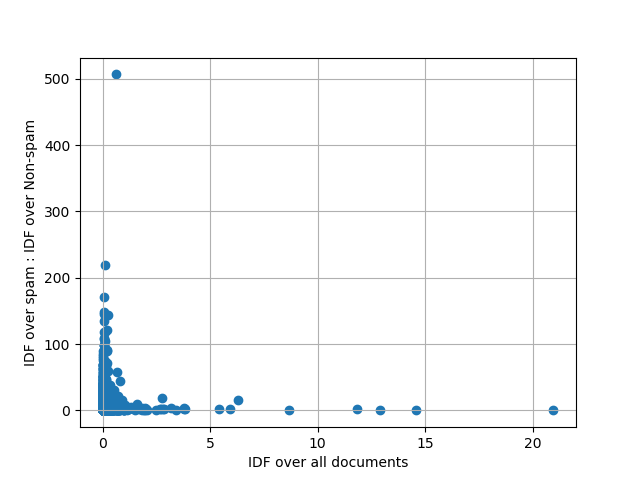

E:\Anaconda3.5.2.0\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [209]:
# Visualize scatter plot for inter-doc frequency of words over all documents vs
# ratio between inter-doc frequency of words over all spam and non-spam documents
plt.close(1)
fig1 = plt.figure(1)
plt.clf()

plt.xlabel("IDF over all documents")
plt.ylabel("IDF over spam : IDF over Non-spam")
plt.grid()

plt.scatter(inter_doc_freq, inter_doc_freq_spam/inter_doc_freq_not_spam)

In [210]:
# Arrange the frequencies in a descending order for each word
from pandas import ExcelWriter
sorted_index = np.flip(np.argsort(inter_doc_freq), axis=0)
all_words = (np.asarray(list(word_map.keys())))[sorted_index]
sorted_avg_freq = avg_freq[sorted_index]
sorted_inter_freq = inter_doc_freq[sorted_index]
sorted_inter_freq_spam = inter_doc_freq_spam[sorted_index]
sorted_inter_freq_not_spam = inter_doc_freq_not_spam[sorted_index]
sorted_intra_freq = intra_doc_freq[sorted_index]

all_data = np.vstack((all_words.T, sorted_inter_freq.T))
all_data = np.vstack((all_data, sorted_inter_freq_spam.T))
all_data = np.vstack((all_data, sorted_inter_freq_not_spam.T))
all_data = np.vstack((all_data, sorted_avg_freq.T))
all_data = np.vstack((all_data, sorted_intra_freq.T))
all_data = all_data.T

df = pd.DataFrame(all_data, columns=['Word', 'Inter-Doc Freq(All)', 'Inter-Doc Freq(Spam)', 'Inter-Doc Freq(Not Spam)', 'Average Freq.', 'Intra-Doc Freq'])


In [211]:
# Save the table as an Excel File
table_path = "word_frequency_no_stop_no_stem.xlsx"
excel_writer = ExcelWriter(table_path)
df.to_excel(excel_writer, index=True, sheet_name="Sheet1")
excel_writer.save()

In [212]:
# Obtain Stop-words
stop_words = all_words[sorted_inter_freq >= 1]
print(stop_words)

['the' 'of' 'and' 'to' 'in' 'you' 'for' 'is' 'on' 'this' 'that' 'be' 'it'
 'are' 'will' 'your' 'with' 'or' 'as' 'by' 'from' 'have' 'university' 'at'
 'language' 'we' 'not' "'s" 'can' '20' 'all' 'an' 'if' 'do' '00' 'one'
 'information' 'our' 'more' 'no' 'subject:']


In [213]:
# Remove stop words from all texts
stop_removed_text = []
stop_removed_label = []
for i in range(len(raw_text)):
    #print("Left: " + str(len(raw_text)-i))
    stop_removed = []
    for j in range(len(raw_text[i])):
        word = raw_text[i][j].lower()
        if not (word in stop_words):
            stop_removed.append(word)
    if len(stop_removed) > 0:
        stop_removed_text.append(stop_removed)
        stop_removed_label.append(labels[i])
print("Total Stop removed training data: " + str(len(stop_removed_text)))

stop_removed_text_eval = []
stop_removed_label_eval= []
for i in range(len(raw_text_eval)):
    #print("Left: " + str(len(raw_text_eval)-i))
    stop_removed = []
    for j in range(len(raw_text_eval[i])):
        word = raw_text_eval[i][j].lower()
        if not (word in stop_words):
            stop_removed.append(word)
    if len(stop_removed) > 0:
        stop_removed_text_eval.append(stop_removed)
        stop_removed_label_eval.append(labels_eval[i])
        
print("Total Stop removed evaluation data: " + str(len(stop_removed_text_eval)))

Total Stop removed training data: 1184
Total Stop removed evaluation data: 297


# Data PreProcessing

## 2. Stemming
Stemming techniques are used to find out the root/stem of a word. Stemming converts words to their stems, which incorporates a great deal of language-dependent linguistic knowledge. Behind stemming, the hypothesis is that words with the same stem or word root mostly describe same or relatively close concepts in text and so words can be conflated by using stems. For example, the words, user, users, used, using all can be stemmed to the word 'USE'. In the present work, the Porter Stemmer algorithm, which is the most commonly used algorithm in English, is used. 

# Feature Extraction

Feature extraction is performed for identifying spam and non-spam text from a set of documents where each document contains a single text corpus. The features obtained from each text corpus are as follows:

## Total Inter-Document Frequency over all documents

Sum of inter-document frequency over all documents($F_R(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over all documents($T_{F_R}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R}(d) = \sum_{i=0}^m F_R(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R(W) = \frac{\sum_{i, j}^{n, m} X_j^{d_i}}{\sum_i^{n} 1}
\end{equation}

## Total Inter-Document Frequency over spam documents

Sum of inter-document frequency over spam documents($F_R^S(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over spam documents($T_{F_R^S}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R^S}(d) = \sum_{i=0}^m F_R^S(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R^S(W) = \frac{\sum_{i, j}^{p, m} X_j^{d_i}}{\sum_i^{p} 1}
\end{equation}

## Total Inter-Document Frequency over Non-Spam documents

Sum of inter-document frequency over non-spam documents($F_R^N(W)$) for each word in the text corpus will be known as the total inter-dependent frequency over non-spam documents($T_{F_R^N}$). If the word is not enlisted in the word-map then its inter-document frequency is considered as zero (in order to exclude the word from calculation). The equation is as follows:

\begin{equation}
T_{F_R^N}(d) = \sum_{i=0}^m F_R^N(W_i)
\end{equation}

Here, $F_R(W)$ is the inter-document frequency of the word obtained over all documents(d).

\begin{equation}
F_R^N(W) = \frac{\sum_{i, j}^{n-p, m} X_j^{d_i}}{\sum_i^{n-p} 1}
\end{equation}

In [215]:
# Extract the three features from each document thereby creating the feature vector
def calculate_total_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq[np.where(all_words == word)[0]]
    return total_idf

def calculate_spam_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq_spam[np.where(all_words == word)[0]]
    return total_idf

def calculate_nspam_idf(document):
    total_idf = 0
    for i in range(len(document)):
        word = document[i].lower()
        if word in all_words:
            total_idf += sorted_inter_freq_not_spam[np.where(all_words == word)[0]]
    return total_idf

def calculate_all_idfs(document):
    idf = 0
    idfs = 0
    idfn = 0    
    for i in range(len(document)):
        word = document[i].lower()
        loc = np.where(all_words == word)[0]
        if len(loc) > 0:
            idf += sorted_inter_freq[loc]
            idfs += sorted_inter_freq_spam[loc]
            idfn += sorted_inter_freq_not_spam[loc]
    return [idf, idfs, idfn]

feature_data = []
feature_label = []
for i in range(len(stop_removed_text)):
    #print("Left: " + str(len(stop_removed_text) - i))
    feature_data.append(calculate_all_idfs(stop_removed_text[i]))
    feature_label.append(stop_removed_label[i])
feature_data = np.asarray(feature_data)
feature_data = feature_data/feature_data.max()
feature_data = np.reshape(feature_data, (-1, 3))
feature_label = np.asarray(feature_label)
print("Feature vector shape for training data: " + str(feature_data.shape))


feature_data_eval = []
feature_label_eval = []
for i in range(len(stop_removed_text_eval)):
    #print("Left: " + str(len(stop_removed_text_eval) - i))
    feature_data_eval.append(calculate_all_idfs(stop_removed_text_eval[i]))
    feature_label_eval.append(stop_removed_label_eval[i])
feature_data_eval = np.asarray(feature_data_eval)
feature_data_eval = feature_data_eval/feature_data_eval.max()
feature_data_eval = np.reshape(feature_data_eval, (-1, 3))
feature_label_eval = np.asarray(feature_label_eval)
print("Feature vector shape for evaluation data: " + str(feature_data_eval.shape))


Feature vector shape for training data: (1184, 3)
Feature vector shape for evaluation data: (297, 3)


<IPython.core.display.Javascript object>


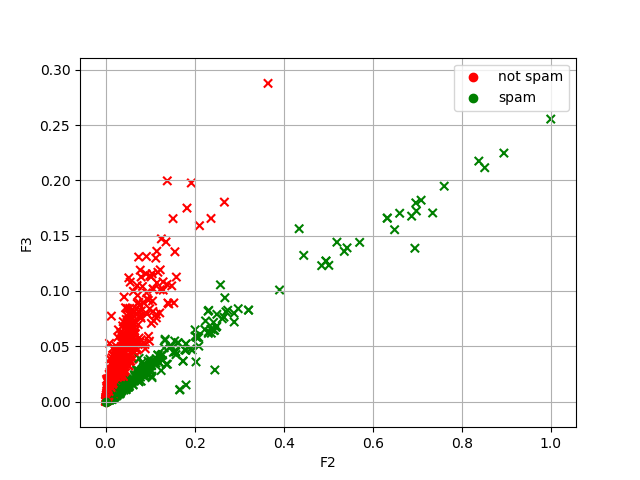

In [216]:
plt.close(2)
fig2 = plt.figure(2)
plt.clf()

plt.xlabel("F2")
plt.ylabel("F3")
plt.grid()

colors = ['red', 'green']
plt.scatter(feature_data[:, 1], feature_data[:, 2], c=np.asarray(colors)[feature_label], marker='x')
plt.scatter([0], [0], c=colors[0], label=label_map[0])
plt.scatter([0], [0], c=colors[1], label=label_map[1])

plt.legend()


# Feature Extraction(2)

## Term Frequency - Inverse Document Frequency(TF-IDF)

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

The equation for term-frequency-inverse-dcument-frequency(tf-idf) of a term(e.g. word) 't' in a document corpus or dataset '$D = {d_1, d_2, ..., d_n}$' is as follows:

\begin{equation}
tf-idf(t, D) = tf(t, d) . idf(t, D)
\end{equation}

Here,

- $tf(t,d)$ is the term-frequency(tf) of a term 't' in a document 'd' that belongs to a document corpus 'D'.

- $idf(t, D)$ is the inverse document frequency(idf) of a term 't' in a document corpus 'D'.


## Term Frequency

Suppose we have a set of English text documents and wish to rank which document is most relevant to the query, "the brown cow". A simple way to start out is by eliminating documents that do not contain all three words "the", "brown", and "cow", but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, in the case where the length of documents varies greatly, adjustments are often made (see definition below). The first form of term weighting is due to Hans Peter Luhn (1957) which may be summarized as:

- The weight of a term that occurs in a document is simply proportional to the term frequency.

The equation for term frequency '$tf(t,d)$' of a term 't' (e.g. word) in the document 'd' is as follows:
\begin{equation}
tf(t,d) = \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}}
\end{equation}

Here,

- $f_{t,d}$ is the raw count of the term 't' i.e. the number of times where 't' appears in the document 'd'.

- $tf(t,d)$ is the number of times the term appeared in document 'd' divided by the total number of terms '$f_{t', d}$' in docment 'd'. $t'$ is a term that appears in document 'd'.

Other variants of term frequency includes:

1. Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;


2. Logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);


3. Augmented frequency, to prevent a bias towards longer documents, e.g. raw frequency divided by the raw frequency of the most occurring term in the document:



## Inverse Document Frequency

Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "brown" and "cow". The term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "brown" and "cow". Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

Karen Spärck Jones (1972) conceived a statistical interpretation of term specificity called Inverse Document Frequency (idf), which became a cornerstone of term weighting:

- The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.

The equation for Inverse Document Frequency(IDF) '$idf(t, D)$' for a term 't' in a document corpus or dataset 'D' is as follows:

\begin{equation}
idf(t, D) = log \frac{N}{| {d \in D : t \in D} |}
\end{equation}

Here,

- N is the total number of documents(d) in the dataset or docment corpus 'D'.

- $| {d \in D : t \in D} |$ is the number of documents(d) where the term(t) appears. If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to


\begin{equation}
idf(t, D) = log \frac{N}{| 1 + {d \in D : t \in D} |}
\end{equation}


In [222]:
# Calculate raw count for a word in a text
def calculate_raw_count(term, document):
    return len(np.where(np.asarray(document) == term)[0])

# Calculate term-frequency for a word in a text corpus
def calculate_term_frequency(term, document):
    raw_count_term = calculate_raw_count(term, document)
    total_counts = np.sum(np.unique(np.asarray(document), return_counts=True)[1])
    return raw_count_term/total_counts

# Calculate boolean term-freuquency for a word in a text corpus
def calculate_boolean_term_frequency(term , document):
    if term in document:
        return 1
    else:
        return 0
    
# Calculate logarithmically scaled frequency
def calculate_log_scale_frequency(term, document):
    return np.log(1 + calculate_raw_count(term, document))

# Calculate Augmented Frequency of a word in a document
def calculate_augmented_frequency(term, document):
    values, counts = np.unique(np.asarray(document), return_counts=True)
    return calculate_raw_count(term, document) / calculate_raw_count(values[np.argmax(counts)], document)


# Calculate inverse-document-frequency of a word in a document
def calculate_idf(term, doc_corpus):
    count = 0
    for i in range(len(doc_corpus)):
        if term in doc_corpus[i]:
            count += 1
    return np.log(len(doc_corpus) / (1+count))

def calculate_tf_idf(term, doc, doc_corpus):
    return calculate_term_frequency(term, doc) * calculate_idf(term, doc_corpus)
# Create Feature Vector using tf-idf extracted from each document or text

# Create a modified word-map by removing words according to the preprocessing step mentioned in DOI: 10.1109/WI.2003.1241300
modified_word_map = []
highest_chars = 20  # Maximum characters that a valid word can have
for word in word_map.keys():
    # Do not add words that only appears once in the corpus or dataset
    if len(word_map[word]) > 1:
        # Do not add words with characters greater than 20
        if len(word) < highest_chars:
            
            modified_word_map.append(word)
print("Original wordmap: " + str(len(word_map.keys())) + " Modified wordmap: " + str(len(modified_word_map)))

term_frequencies = []
inverse_document_frequency = []

for i in range(len(stop_removed_text)):
    print("Left: " + str(len(stop_removed_text) - i))
    tf = []
    #idf = []
    for word in modified_word_map:
        tf.append(calculate_term_frequency(word, stop_removed_text[i]))
        #idf.append(calculate_idf(word, stop_removed_text))
    term_frequencies.append(tf)
    #inverse_document_frequency.append(idf)
    
term_frequencies = np.asarray(term_frequencies)
#inverse_document_frequency = np.asarray(inverse_document_frequency)
print("Feature vector shape for training dataset: " + str(term_frequencies.shape))

term_frequencies_eval = []
inverse_document_frequency_eval = []


for i in range(len(stop_removed_text_eval)):
    print("Left: " + str(len(stop_removed_text_eval) - i))
    tf = []
    #idf = []
    for word in modified_word_map:
        tf.append(calculate_term_frequency(word, stop_removed_text_eval[i]))
        #idf.append(calculate_idf(word, stop_removed_text))
    term_frequencies_eval.append(tf)
    #inverse_document_frequency.append(idf)
    
term_frequencies_eval = np.asarray(term_frequencies_eval)
#inverse_document_frequency = np.asarray(inverse_document_frequency)
print("Feature vector shape for evaluation dataset: " + str(term_frequencies_eval.shape))

Original wordmap: 37232 Modified wordmap: 19261
Left: 1184
Left: 1183
Left: 1182
Left: 1181
Left: 1180
Left: 1179
Left: 1178
Left: 1177
Left: 1176
Left: 1175
Left: 1174
Left: 1173
Left: 1172
Left: 1171
Left: 1170
Left: 1169
Left: 1168
Left: 1167
Left: 1166
Left: 1165
Left: 1164
Left: 1163
Left: 1162
Left: 1161
Left: 1160
Left: 1159
Left: 1158
Left: 1157
Left: 1156
Left: 1155
Left: 1154
Left: 1153
Left: 1152
Left: 1151
Left: 1150
Left: 1149
Left: 1148
Left: 1147
Left: 1146
Left: 1145
Left: 1144
Left: 1143
Left: 1142
Left: 1141
Left: 1140
Left: 1139
Left: 1138
Left: 1137
Left: 1136
Left: 1135
Left: 1134
Left: 1133
Left: 1132
Left: 1131
Left: 1130
Left: 1129
Left: 1128
Left: 1127
Left: 1126
Left: 1125
Left: 1124
Left: 1123
Left: 1122
Left: 1121
Left: 1120
Left: 1119
Left: 1118
Left: 1117
Left: 1116
Left: 1115
Left: 1114
Left: 1113
Left: 1112
Left: 1111
Left: 1110
Left: 1109
Left: 1108
Left: 1107
Left: 1106
Left: 1105
Left: 1104
Left: 1103
Left: 1102
Left: 1101
Left: 1100
Left: 1099
Left: 

Left: 388
Left: 387
Left: 386
Left: 385
Left: 384
Left: 383
Left: 382
Left: 381
Left: 380
Left: 379
Left: 378
Left: 377
Left: 376
Left: 375
Left: 374
Left: 373
Left: 372
Left: 371
Left: 370
Left: 369
Left: 368
Left: 367
Left: 366
Left: 365
Left: 364
Left: 363
Left: 362
Left: 361
Left: 360
Left: 359
Left: 358
Left: 357
Left: 356
Left: 355
Left: 354
Left: 353
Left: 352
Left: 351
Left: 350
Left: 349
Left: 348
Left: 347
Left: 346
Left: 345
Left: 344
Left: 343
Left: 342
Left: 341
Left: 340
Left: 339
Left: 338
Left: 337
Left: 336
Left: 335
Left: 334
Left: 333
Left: 332
Left: 331
Left: 330
Left: 329
Left: 328
Left: 327
Left: 326
Left: 325
Left: 324
Left: 323
Left: 322
Left: 321
Left: 320
Left: 319
Left: 318
Left: 317
Left: 316
Left: 315
Left: 314
Left: 313
Left: 312
Left: 311
Left: 310
Left: 309
Left: 308
Left: 307
Left: 306
Left: 305
Left: 304
Left: 303
Left: 302
Left: 301
Left: 300
Left: 299
Left: 298
Left: 297
Left: 296
Left: 295
Left: 294
Left: 293
Left: 292
Left: 291
Left: 290
Left: 289


# Feature Selection

Source Journal: A comparative study on feature selection in text categorization
First Author: Yiming Yang


Feature Selection is a technique used in bag of word model in order to reduce the number of unique terms (e.g. words) in the document corpus by removing the terms which carry the least amount of information useful for categorization. Generally, even a small document or text corpus may contain hundreds or even thousands of unique terms. If each term is treated as a feature vector for each document then the dimension of feature vector will become very large and unmanageable for classification. Therefore, different dimensionality reduction techniques (also known as feature selection techniques) are used on the feature vector obtained after extracting features from a document corpus or dataset. It can reduce the number of unique words drastically e.g. from 9000 to 1000 since most of the words or terms used in a text carry negligible information. Some of the feature selction techniques are discussed below.

## Document-Frequency Thresholding (DFT)

Document Frequency(DF) of a term 't' is the number of documents in which the term occurs. Usually, DF is calculated for each  unique term in the training corpus or training set and the terms posessing a DF lower than predefined threshold are omitted from the feature vector space. This process of feature selection is known as Document-Frequency Thresholding. The basic assumption is that the terms are either non-informative or not influential in global performance. 


## Information Gain(IG)

Information Gain(IG) is frequently employed as a term-goodness criterion in the field of machine learning. It measures the number of bits of information obtained for category prediction by knowing the presence or absence of a term in a document. Let $\{c\}_{i=1}^m$ denote the set of categories in the target space. The IG of a term 't' is defined as:

\begin{equation}
G(t) = - \sum_{i=1}^m P_r(c_i) log P_r(c_i) + P_r(t) \sum_{i=1}^m P_r(c_i | t) log P_r(c_i | t) + P_r(\bar{t}) \sum_{i=1}^m P_r(c_i | \bar{t}) log P_r(c_i | \bar{t})
\end{equation}

During feature selection IG is calculated for each unique term and the terms with value lower than a predefined threshold are eliminated from the feature vector space. '$P_r(c)$' denotes the probability of category 'c'.


## Mutual Information(MI)

Mutual Information(MI) is a criterion commonly used in statistical language modelling of word associations and related applications. If one considers a two way continency table for a category 'c' and a term 't', where 'A' is the number of times 'c' and 't' co-occur, 'B' is the number of times 't' occur without 'c', 'C' is the number of times 'c' occurs without 't' and 'N' is the total number of documents then the MI between 't' and'c' is defined as follows:

\begin{equation}
I(t,c) \approx log \frac{AN}{(A+C)(A+B)}
\end{equation}

$I(t,c)$ has a natural value of zero if 't' and 'c' are independent. In order to measure the goodness of a term in a global feature selection, category-specific scores of a term are combined in two alternate ways:

\begin{equation}
I_{avg}(t) = \sum_{i=1}^m P_r(c_i) I(t, c_i)
\end{equation}

\begin{equation}
I_{max}(t) = max_{i=1}^m \{I(t,c_i)\}
\end{equation}

A weakness of MI is that the score is strongly influenced by the marginal probabilities of terms.


## Chi-Squared Statistics($\chi^2$)

It measures the lack of independence between a term 't' and a category 'c' and can be compared with the Chi-Squared Distribution with one degree of freedom in order to judge extremeness. If one considers a two way continency table for a category 'c' and a term 't', where 'A' is the number of times 'c' and 't' co-occur, 'B' is the number of times 't' occur without 'c', 'C' is the number of times 'c' occurs without 't', 'D' is the number of times neither c nor t occurs and 'N' is the total number of documents, the term-goodness measure is defined as:

\begin{equation}
\chi^2(t, c) = \frac{N(AD-CB)^2}{(A+C)(B+D)(A+B)(C+D)}
\end{equation}

It has a natural value of zero of term 't' and category 'c' are independent. $\chi^2$ is calcualated for each unique term 't' and category 'c' and the category specific score of each term is combined into two scores using the following equation:

\begin{equation}
\chi_{avg}^2(t) = \sum_{i=1}^m P_r(c_i) \chi^2(t, c_i)
\end{equation}

\begin{equation}
\chi_{max}^2(t) = max_{i=1}^m \{\chi^2(t, c_i)\}
\end{equation}

The computation of $\chi^2$ score has a quadratic computational complexity similar to MI and IG. A normal difference between $\chi^2$ and MI is that $\chi^2$ is a normalized value and hence is comparable across terms for the same category. However, this normalization breaks down if any cell in the contingency table is lightly populated which is the case for low frequency terms.

In [223]:
# Estimate important features/words using Document-Frequency Thresholding
def calculate_important_features_dft(wordmap, min_threshold, max_threshold, keys=None):
    imp_features = []
    counter = 0
    if keys is None:
        words = wordmap.keys()
    else:
        words = keys
    for word in words:
        docs, _ = np.unique([ wordmap[word][i][0] for i in range(len(wordmap[word]))], return_counts=True)
        if min_threshold <= len(docs) <= max_threshold:
            imp_features.append(counter)
        counter += 1
    return np.asarray(imp_features)
keys = np.asarray(modified_word_map.copy())

dft_min_thresh = int(len(stop_removed_text)/4)  # Important words should appear atleast on one fourth of the document corpus
dft_max_thresh = int(len(stop_removed_text)/2) # Important words should appear atmost on one half of the document corpus
dft_features = calculate_important_features_dft(word_map, dft_min_thresh, dft_max_thresh)
print("Total Important features: " + str(len(dft_features)) + " out of " + str(len(keys)))
    

Total Important features: 60 out of 19261


In [224]:
# Estimate importan features/words using Variance Thresholding
from sklearn.feature_selection import VarianceThreshold
   

total_features = 256  # Highest scoring 256 features will be selected as important features
v = VarianceThreshold()
v.fit(term_frequencies.copy(), stop_removed_label.copy())
vt_features = np.flip(np.argsort(v.variances_), axis=0)[:total_features]
print(np.asarray(modified_word_map)[vt_features])


['3d' 'free' 'http' 'linguistics' 'california' 'semiotic' 'circle' 'click'
 'de' 'sex' 'com' 'only' 'www' 'here' 'hollander' 'call' 'english' 'video'
 'languages' 'new' 'please' 'site' 'adults' 'address' 'conference' 'email'
 '000' 'e-mail' 'edu' 'list' 'there' 'any' 'my' 'web' 'me' 'papers'
 'would' 'live' 're' 'degree' 'which' 'who' 'out' '1998' 'about' 'get'
 'html' 'references' 'query' 'like' 'us' 'am' 'book' 'now' 'see'
 'workshop' 'summary' 'thanks' 'but' 'research' 'some' 'discourse' 'just'
 'credit' 'time' 'xxx' 'romance' 'uk' 'has' '30' 'other' 'original'
 'announced' 'know' 'heavy' 'send' 'up' 'theory' 'dare' 'adult' 'onsets'
 'business' 'how' 'japanese' 'infoseek' 'content' 'was' 'mail' 'id'
 'phonology' 'linguistic' 'their' 'speech' 'what' 'going' 'may' 'internet'
 'science' '10' 'want' 'anyone' 'fax' 'subject' 'should' 'most' 'software'
 'abstracts' 'sites' 'ac' 'so' 'german' 'order' 'interested' 'money'
 'addresses' 'pragmatics' 'program' 'gift' 'they' 'does' 'available'


In [228]:
# Modify the feature vector by keeping only the important features
feature_data_vt = term_frequencies[:, vt_features]
feature_data_vt_eval = term_frequencies_eval[:, vt_features]
feature_data_dft = term_frequencies[:, dft_features]
feature_data_dft_eval = term_frequencies_eval[:, dft_features]
print("Feature Data Shape: " + str(feature_data_vt.shape))

Feature Data Shape: (1184, 256)


In [174]:
len(modified_word_map)

21457

# Classification


E:\Anaconda3.5.2.0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>


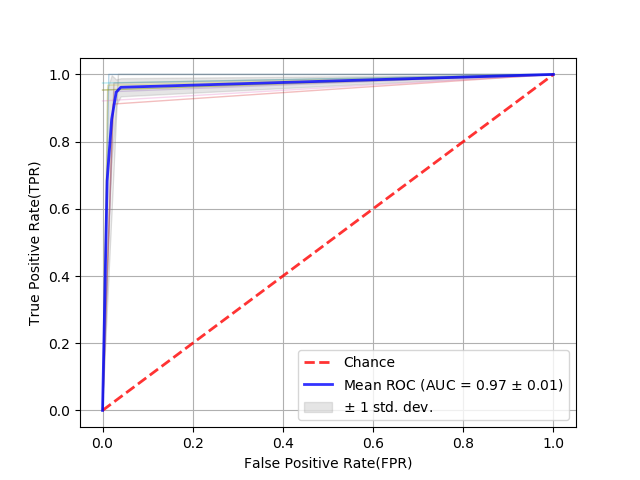

Evaluation Score: 97.64


In [233]:
# Classification using K-Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from scipy import interp
from sklearn.metrics import roc_curve, auc


kf = KFold(n_splits=10)  # 10-Fold Cross Validation

X = np.asarray(feature_data_vt)/feature_data_vt.max()
X_eval = np.asarray(feature_data_vt_eval)/feature_data_vt_eval.max()
y = np.asarray(feature_label)
y_eval = np.asarray(feature_label_eval)
X, y = shuffle(X, y)
X_eval, y_eval = shuffle(X_eval, y_eval)

tprs, fprs, aucs, mean_tprs = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

clf = MLPClassifier(hidden_layer_sizes=(40), activation='relu', solver='adam', shuffle=True, random_state=42, verbose=False)
#clf = KNeighborsClassifier(n_neighbors=3)
#clf = SVC(kernel="rbf", gamma=0.7)
#clf = RandomForestClassifier()
counter = 1
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    clf.fit(X_train, y_train)
    #print( "Classification for fold No. " + str(counter) + ": {0:.2f}".format(clf.score(X_test, y_test)*100) + "%")
    
    prediction = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    mean_tprs.append(interp(mean_fpr, fpr, tpr))
    mean_tprs[-1][0] = 0.0
    counter += 1

plt.close(3)
fig3 = plt.figure(3)
plt.clf()
plt.grid()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

for i in range(len(tprs)):
    plt.plot(fprs[i], tprs[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

mean_tpr = np.mean(mean_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(mean_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

print("Evaluation Score: {0:.2f}".format(clf.score(X_eval, y_eval)*100))